In [ ]:
# @title Default title text
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, zipfile, shutil, glob
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, librosa.display
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


# -------------------------
# 2) Define zip lists and directories
# -------------------------
GOOD_ZIPS = [
  "/content/drive/MyDrive/timing chain.zip",
  "/content/drive/MyDrive/piston spark wav.zip",
  "/content/drive/MyDrive/magneto rotor wav.zip",
  "/content/drive/MyDrive/head engine.zip",
  "/content/drive/MyDrive/exhaust.zip"
]

BAD_ZIPS = [
  "/content/drive/MyDrive/bad engine exhaust.zip",
  "/content/drive/MyDrive/bad piston spark.zip",
  "/content/drive/MyDrive/bad head engine.zip",
  "/content/drive/MyDrive/bad engine magneto rotor.zip",
  "/content/drive/MyDrive/bad timing chain.zip"  # duplicate listed in your message
]


In [ ]:
WORKDIR = "/content/engine_dataset"
GOOD_DIR = os.path.join(WORKDIR, "good")
BAD_DIR = os.path.join(WORKDIR, "bad")
os.makedirs(GOOD_DIR, exist_ok=True)
os.makedirs(BAD_DIR, exist_ok=True)
def safe_unzip(zip_path, target_dir):
    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            print("Extracting", zip_path, "to", target_dir)
            z.extractall(target_dir)
    except Exception as e:
        print("Error extracting", zip_path, ":", e)

# Unzip all good and bad zips into respective folders
for z in GOOD_ZIPS:
    if os.path.exists(z):
        safe_unzip(z, GOOD_DIR)
    else:
        print("Missing:", z)

for z in BAD_ZIPS:
    if os.path.exists(z):
        safe_unzip(z, BAD_DIR)
    else:
        print("Missing:", z)


Extracting /content/drive/MyDrive/timing chain.zip to /content/engine_dataset/good
Extracting /content/drive/MyDrive/piston spark wav.zip to /content/engine_dataset/good
Extracting /content/drive/MyDrive/magneto rotor wav.zip to /content/engine_dataset/good
Extracting /content/drive/MyDrive/head engine.zip to /content/engine_dataset/good
Extracting /content/drive/MyDrive/exhaust.zip to /content/engine_dataset/good
Extracting /content/drive/MyDrive/bad engine exhaust.zip to /content/engine_dataset/bad
Extracting /content/drive/MyDrive/bad piston spark.zip to /content/engine_dataset/bad
Extracting /content/drive/MyDrive/bad head engine.zip to /content/engine_dataset/bad
Extracting /content/drive/MyDrive/bad engine magneto rotor.zip to /content/engine_dataset/bad
Extracting /content/drive/MyDrive/bad timing chain.zip to /content/engine_dataset/bad


In [ ]:
AUDIO_EXT = ("*.wav", "*.flac", "*.mp3", "*.aiff", "*.ogg", "*.m4a")
def gather_audio_files(base_dir):
    files = []
    for ext in AUDIO_EXT:
        files.extend(glob.glob(os.path.join(base_dir, "**", ext), recursive=True))
    return sorted(files)

good_files = gather_audio_files(GOOD_DIR)
bad_files  = gather_audio_files(BAD_DIR)

print("Good files found:", len(good_files))
print("Bad files found :", len(bad_files))


Good files found: 54
Bad files found : 54


In [ ]:
GOOD_ZIPS = [
    "/content/drive/MyDrive/timing chain.zip",
    "/content/drive/MyDrive/piston spark wav.zip",
    "/content/drive/MyDrive/head engine.zip",
    "/content/drive/MyDrive/exhaust.zip"
]

BAD_ZIPS = [
    "/content/drive/MyDrive/bad engine exhaust.zip",
    "/content/drive/MyDrive/bad piston spark.zip",
    "/content/drive/MyDrive/bad timing chain.zip",
    "/content/drive/MyDrive/bad head engine.zip"
]

for z in GOOD_ZIPS:
    safe_unzip(z, GOOD_DIR)

for z in BAD_ZIPS:
    safe_unzip(z, BAD_DIR)


Extracting /content/drive/MyDrive/timing chain.zip to /content/engine_dataset/good
Extracting /content/drive/MyDrive/piston spark wav.zip to /content/engine_dataset/good
Extracting /content/drive/MyDrive/head engine.zip to /content/engine_dataset/good
Extracting /content/drive/MyDrive/exhaust.zip to /content/engine_dataset/good
Extracting /content/drive/MyDrive/bad engine exhaust.zip to /content/engine_dataset/bad
Extracting /content/drive/MyDrive/bad piston spark.zip to /content/engine_dataset/bad
Extracting /content/drive/MyDrive/bad timing chain.zip to /content/engine_dataset/bad
Extracting /content/drive/MyDrive/bad head engine.zip to /content/engine_dataset/bad


In [ ]:
for path in GOOD_ZIPS:
    name = Path(path).stem
    files = gather_audio_files(os.path.join(GOOD_DIR, name))
    print(f"GOOD - {name}: {len(files)} files")

for path in BAD_ZIPS:
    name = Path(path).stem
    files = gather_audio_files(os.path.join(BAD_DIR, name))
    print(f"BAD - {name}: {len(files)} files")


GOOD - timing chain: 11 files
GOOD - piston spark wav: 10 files
GOOD - head engine: 11 files
GOOD - exhaust: 12 files
BAD - bad engine exhaust: 10 files
BAD - bad piston spark: 11 files
BAD - bad timing chain: 11 files
BAD - bad head engine: 10 files


In [ ]:
import librosa
import numpy as np
import os
from pathlib import Path

SAMPLE_RATE = 22050  # standard for librosa
DURATION = 3         # seconds per clip
SAMPLES_PER_CLIP = SAMPLE_RATE * DURATION

def preprocess_audio(file_path, sr=SAMPLE_RATE, duration=DURATION):
    # Load
    y, sr = librosa.load(file_path, sr=sr)

    # Trim silence
    y, _ = librosa.effects.trim(y)

    # Fix length (pad or cut to fixed duration)
    if len(y) > SAMPLES_PER_CLIP:
        y = y[:SAMPLES_PER_CLIP]
    else:
        y = np.pad(y, (0, max(0, SAMPLES_PER_CLIP - len(y))), mode="constant")

    # Normalize
    y = y / np.max(np.abs(y))
    return y


In [ ]:
def extract_features(y, sr=SAMPLE_RATE):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # Aggregate statistics (mean, std)
    features = np.hstack([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(chroma, axis=1), np.std(chroma, axis=1),
        np.mean(mel, axis=1), np.std(mel, axis=1),
        np.mean(contrast, axis=1), np.std(contrast, axis=1)
    ])
    return features


In [ ]:
import numpy as np
from pathlib import Path

# Directories to store unzipped files
GOOD_DIR = "/content/good_audio"
BAD_DIR = "/content/bad_audio"

# Your zip files
GOOD_ZIPS = [
    "/content/drive/MyDrive/timing chain.zip",
    "/content/drive/MyDrive/piston spark wav.zip",
    "/content/drive/MyDrive/head engine.zip",
    "/content/drive/MyDrive/exhaust.zip"
]

BAD_ZIPS = [
    "/content/drive/MyDrive/bad engine exhaust.zip",
    "/content/drive/MyDrive/bad piston spark.zip",
    "/content/drive/MyDrive/bad timing chain.zip",
    "/content/drive/MyDrive/bad head engine.zip"
]

# Unzip all files
for z in GOOD_ZIPS:
    safe_unzip(z, GOOD_DIR)

for z in BAD_ZIPS:
    safe_unzip(z, BAD_DIR)

# Collect all audio file paths
good_files = list(Path(GOOD_DIR).rglob("*.wav"))
bad_files = list(Path(BAD_DIR).rglob("*.wav"))

# Initialize feature and label arrays
X, y = [], []

# Map labels
label_map = {
    "timing chain": 0,
    "piston spark wav": 1,
    "head engine": 2,
    "exhaust": 3,
    "bad timing chain": 4,
    "bad piston spark": 5,
    "bad head engine": 6,
    "bad engine exhaust": 7,
}

# Process audio files and extract features
for path in good_files + bad_files:
    audio = preprocess_audio(path)
    feats = extract_features(audio)

    # Find which category this file belongs to
    folder_name = Path(path).parent.name.lower()
    for key, label in label_map.items():
        if key in folder_name:
            y.append(label)
            X.append(feats)
            break

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("Features shape:", X.shape)
print("Labels:", np.unique(y), "->", y.shape)


Extracting /content/drive/MyDrive/timing chain.zip to /content/good_audio
Extracting /content/drive/MyDrive/piston spark wav.zip to /content/good_audio
Extracting /content/drive/MyDrive/head engine.zip to /content/good_audio
Extracting /content/drive/MyDrive/exhaust.zip to /content/good_audio
Extracting /content/drive/MyDrive/bad engine exhaust.zip to /content/bad_audio
Extracting /content/drive/MyDrive/bad piston spark.zip to /content/bad_audio
Extracting /content/drive/MyDrive/bad timing chain.zip to /content/bad_audio
Extracting /content/drive/MyDrive/bad head engine.zip to /content/bad_audio
Features shape: (79, 334)
Labels: [0 1 2 3 5] -> (79,)


In [ ]:
import os

print("\n--- Folders in GOOD_DIR ---")
for f in os.listdir(GOOD_DIR):
    print(f.lower())

print("\n--- Folders in BAD_DIR ---")
for f in os.listdir(BAD_DIR):
    print(f.lower())



--- Folders in GOOD_DIR ---
head engine
timing chain
exhaust
piston spark wav

--- Folders in BAD_DIR ---
bad piston spark
bad timing chain
bad head engine
bad engine exhaust


--- GOOD AUDIO ---


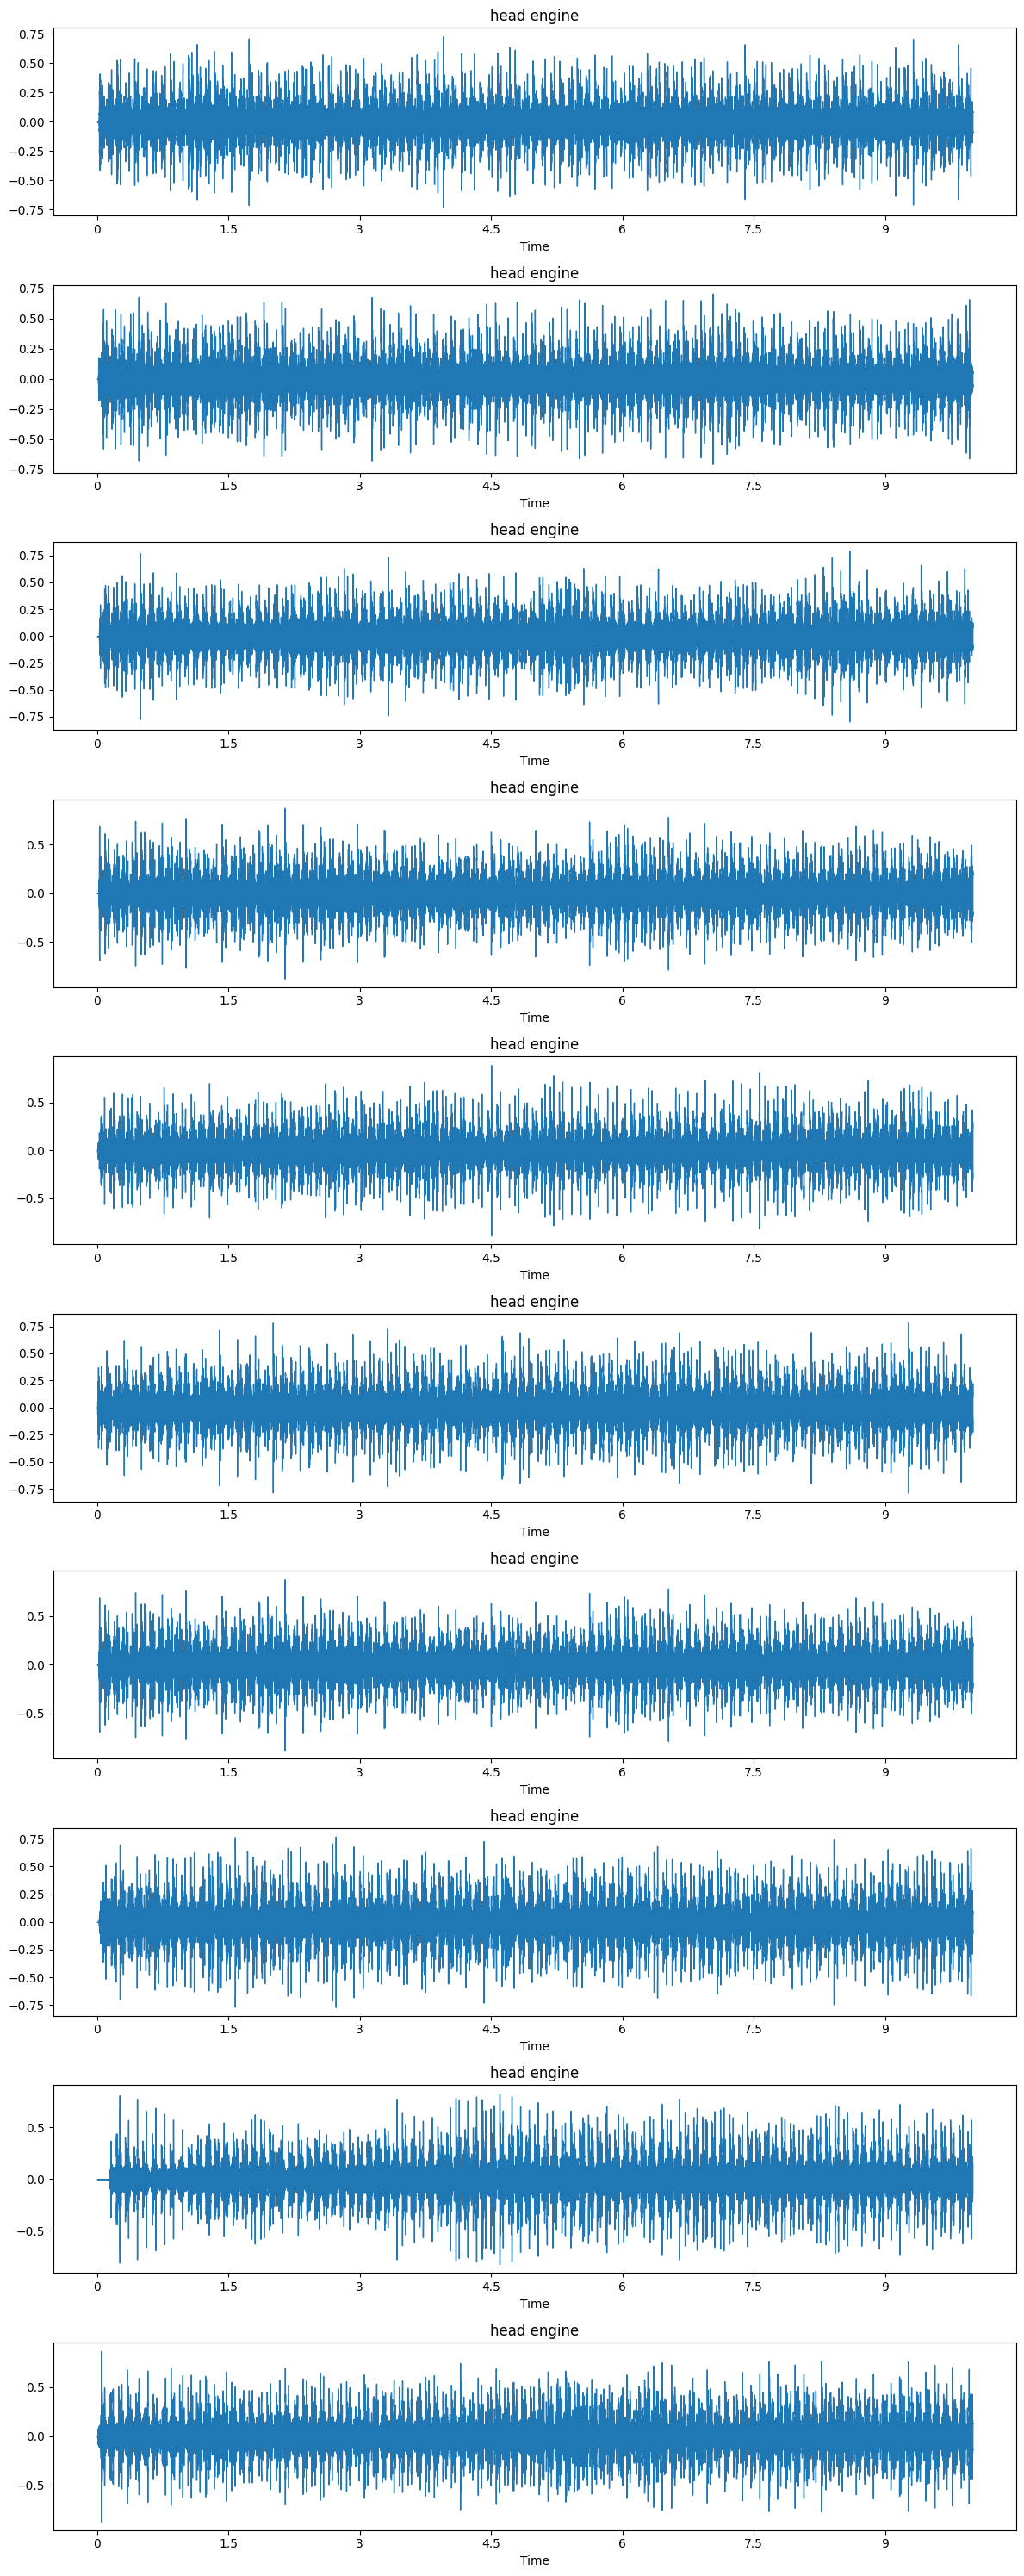

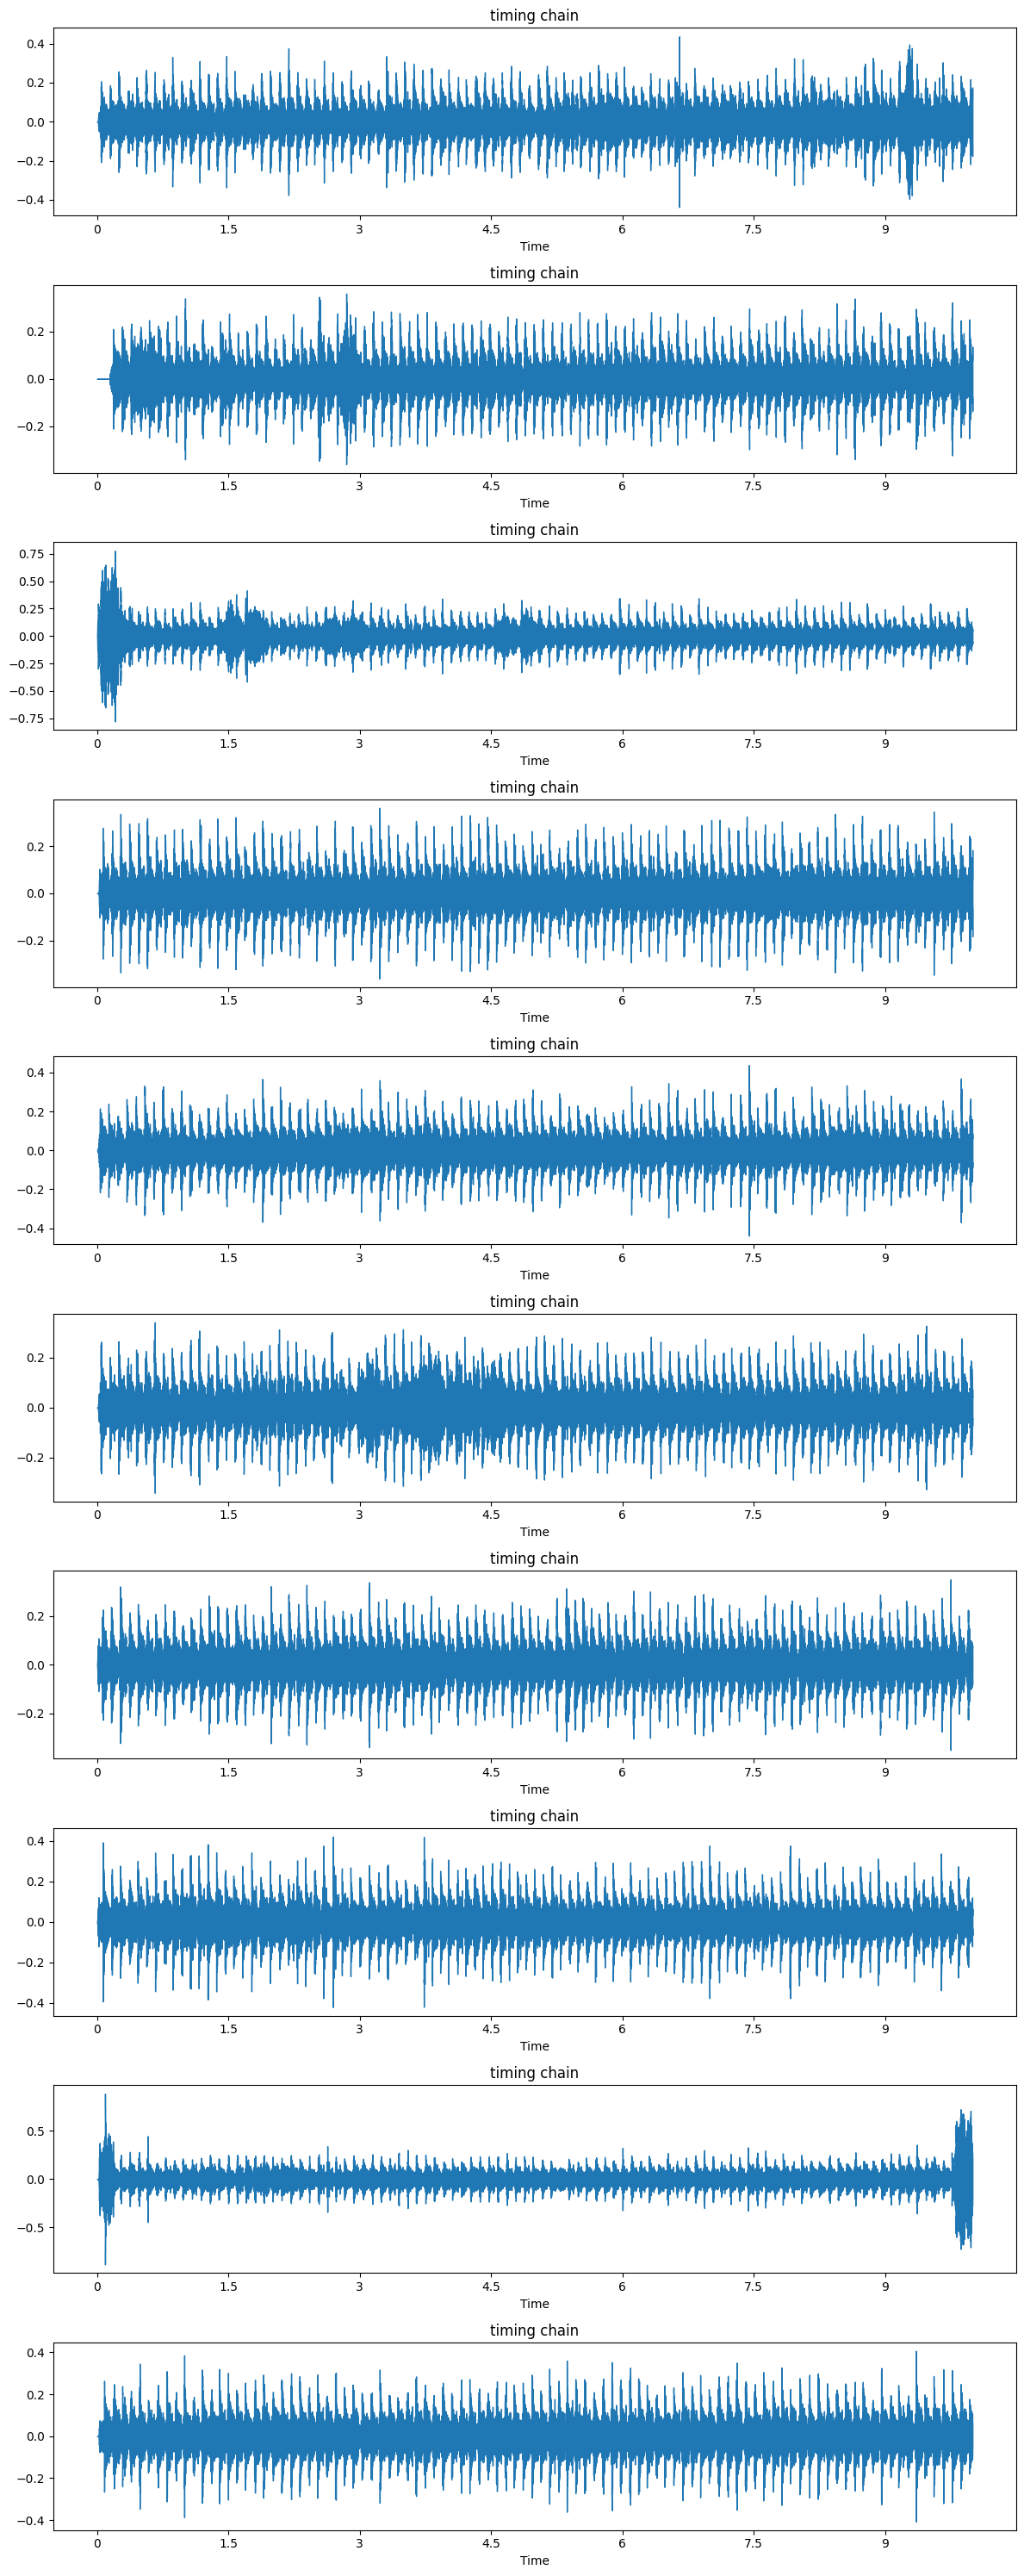

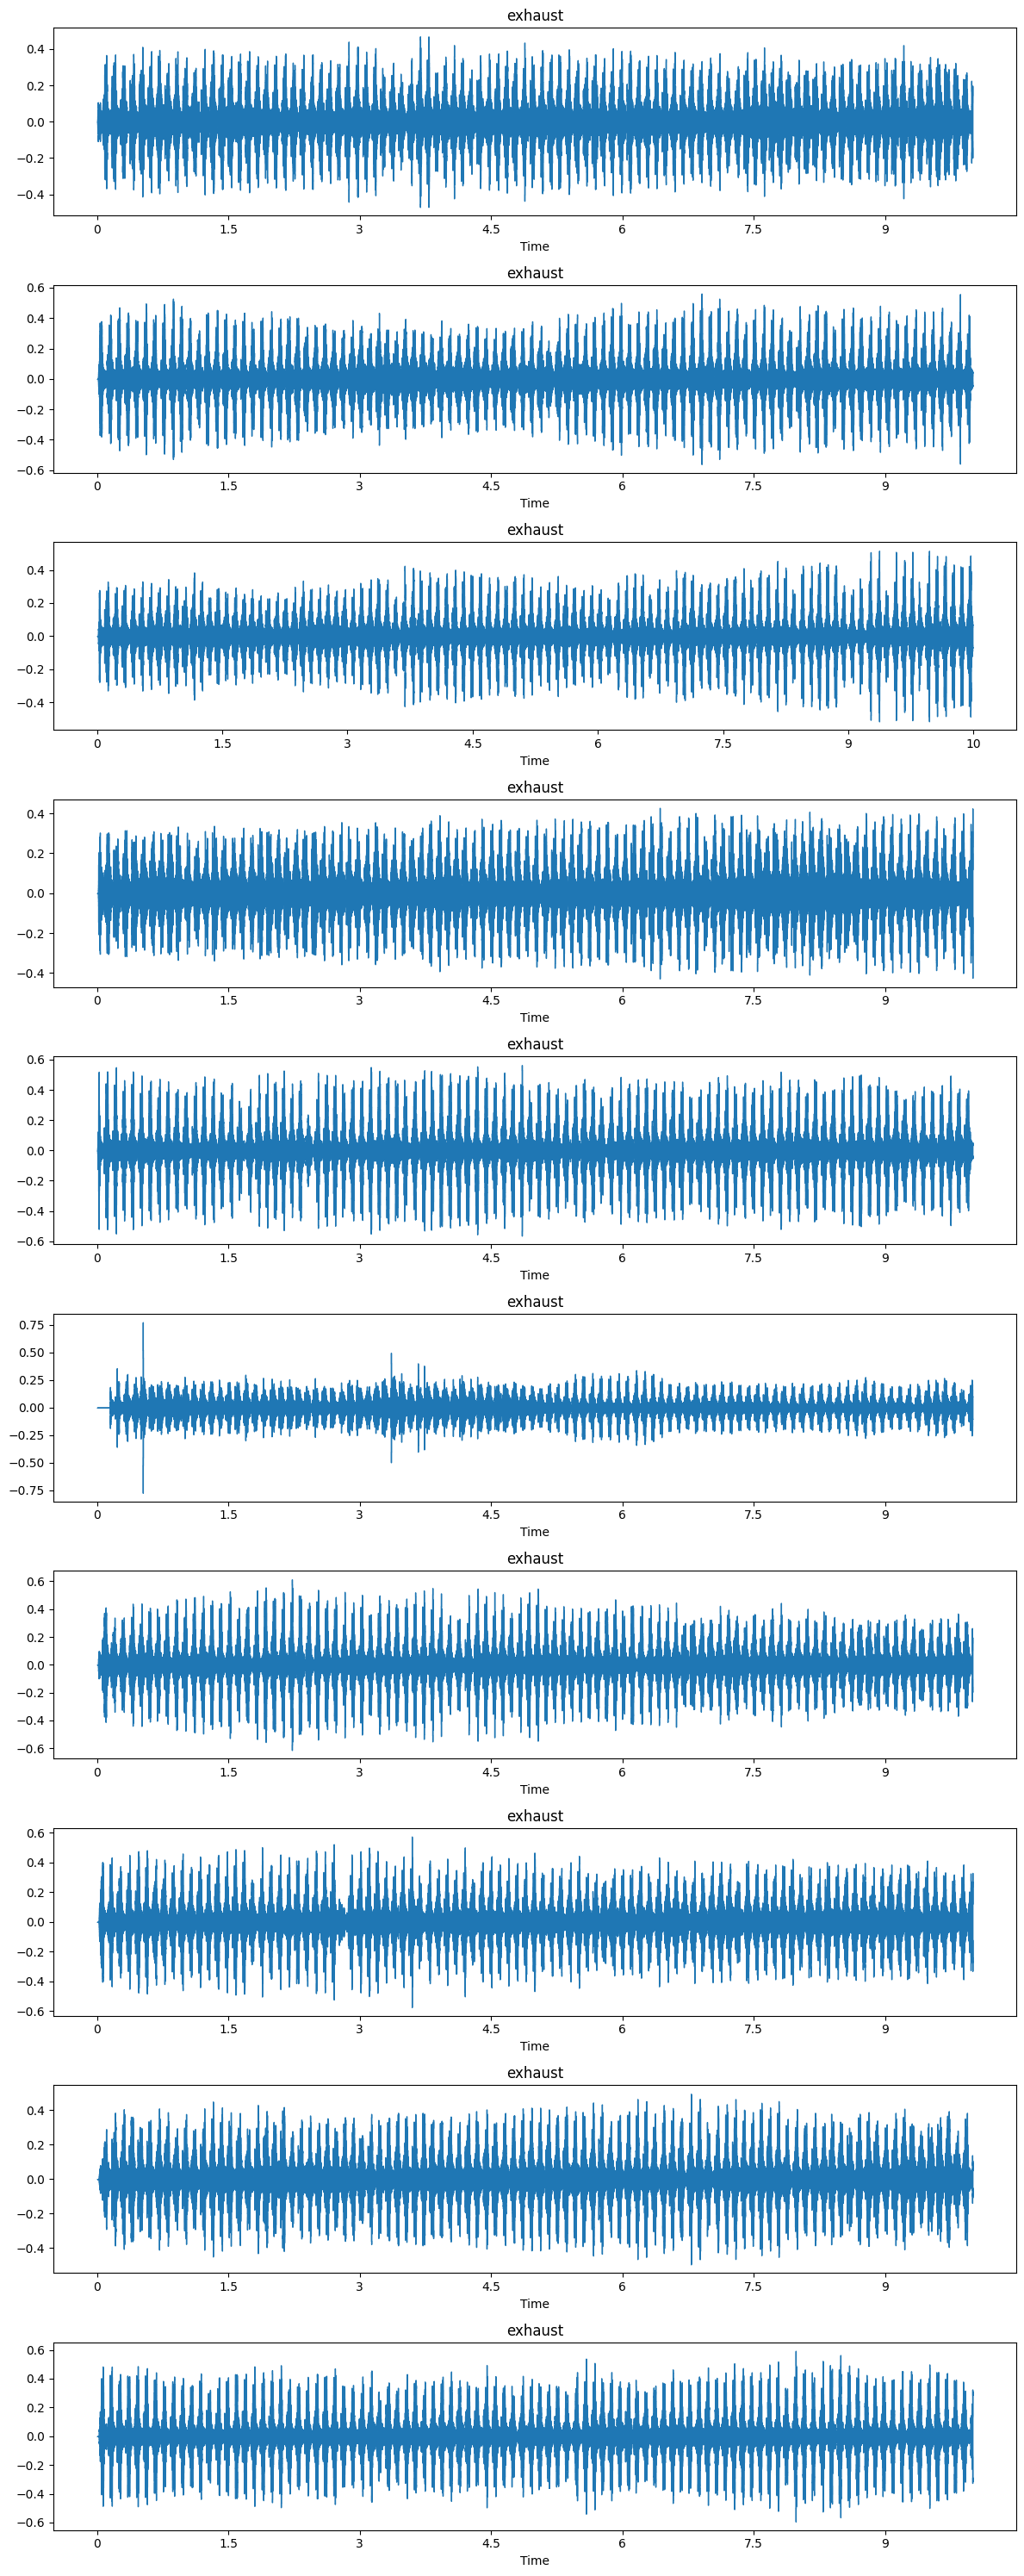

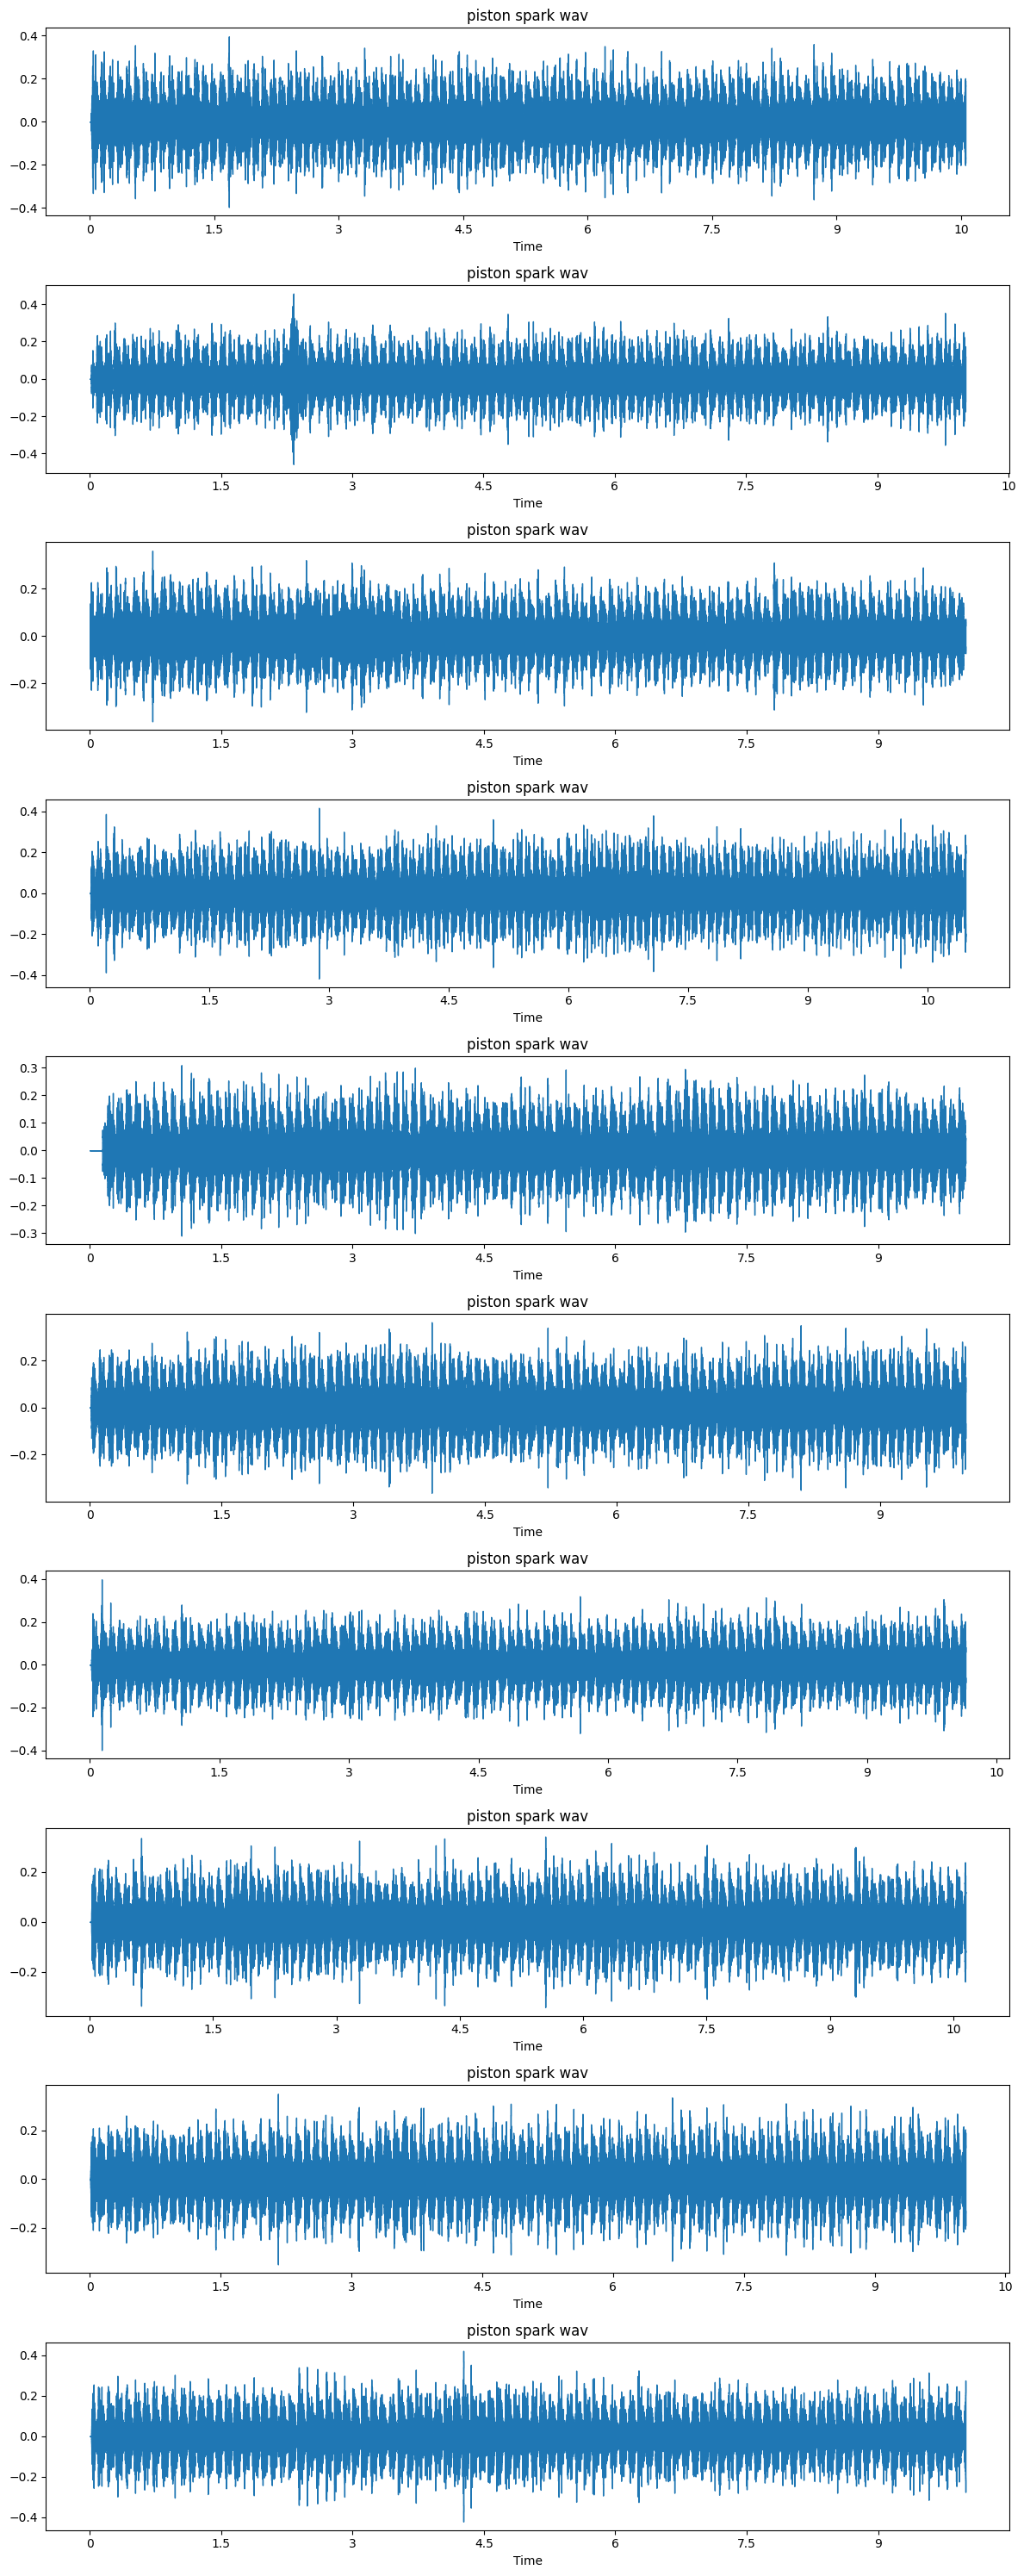

--- BAD AUDIO ---


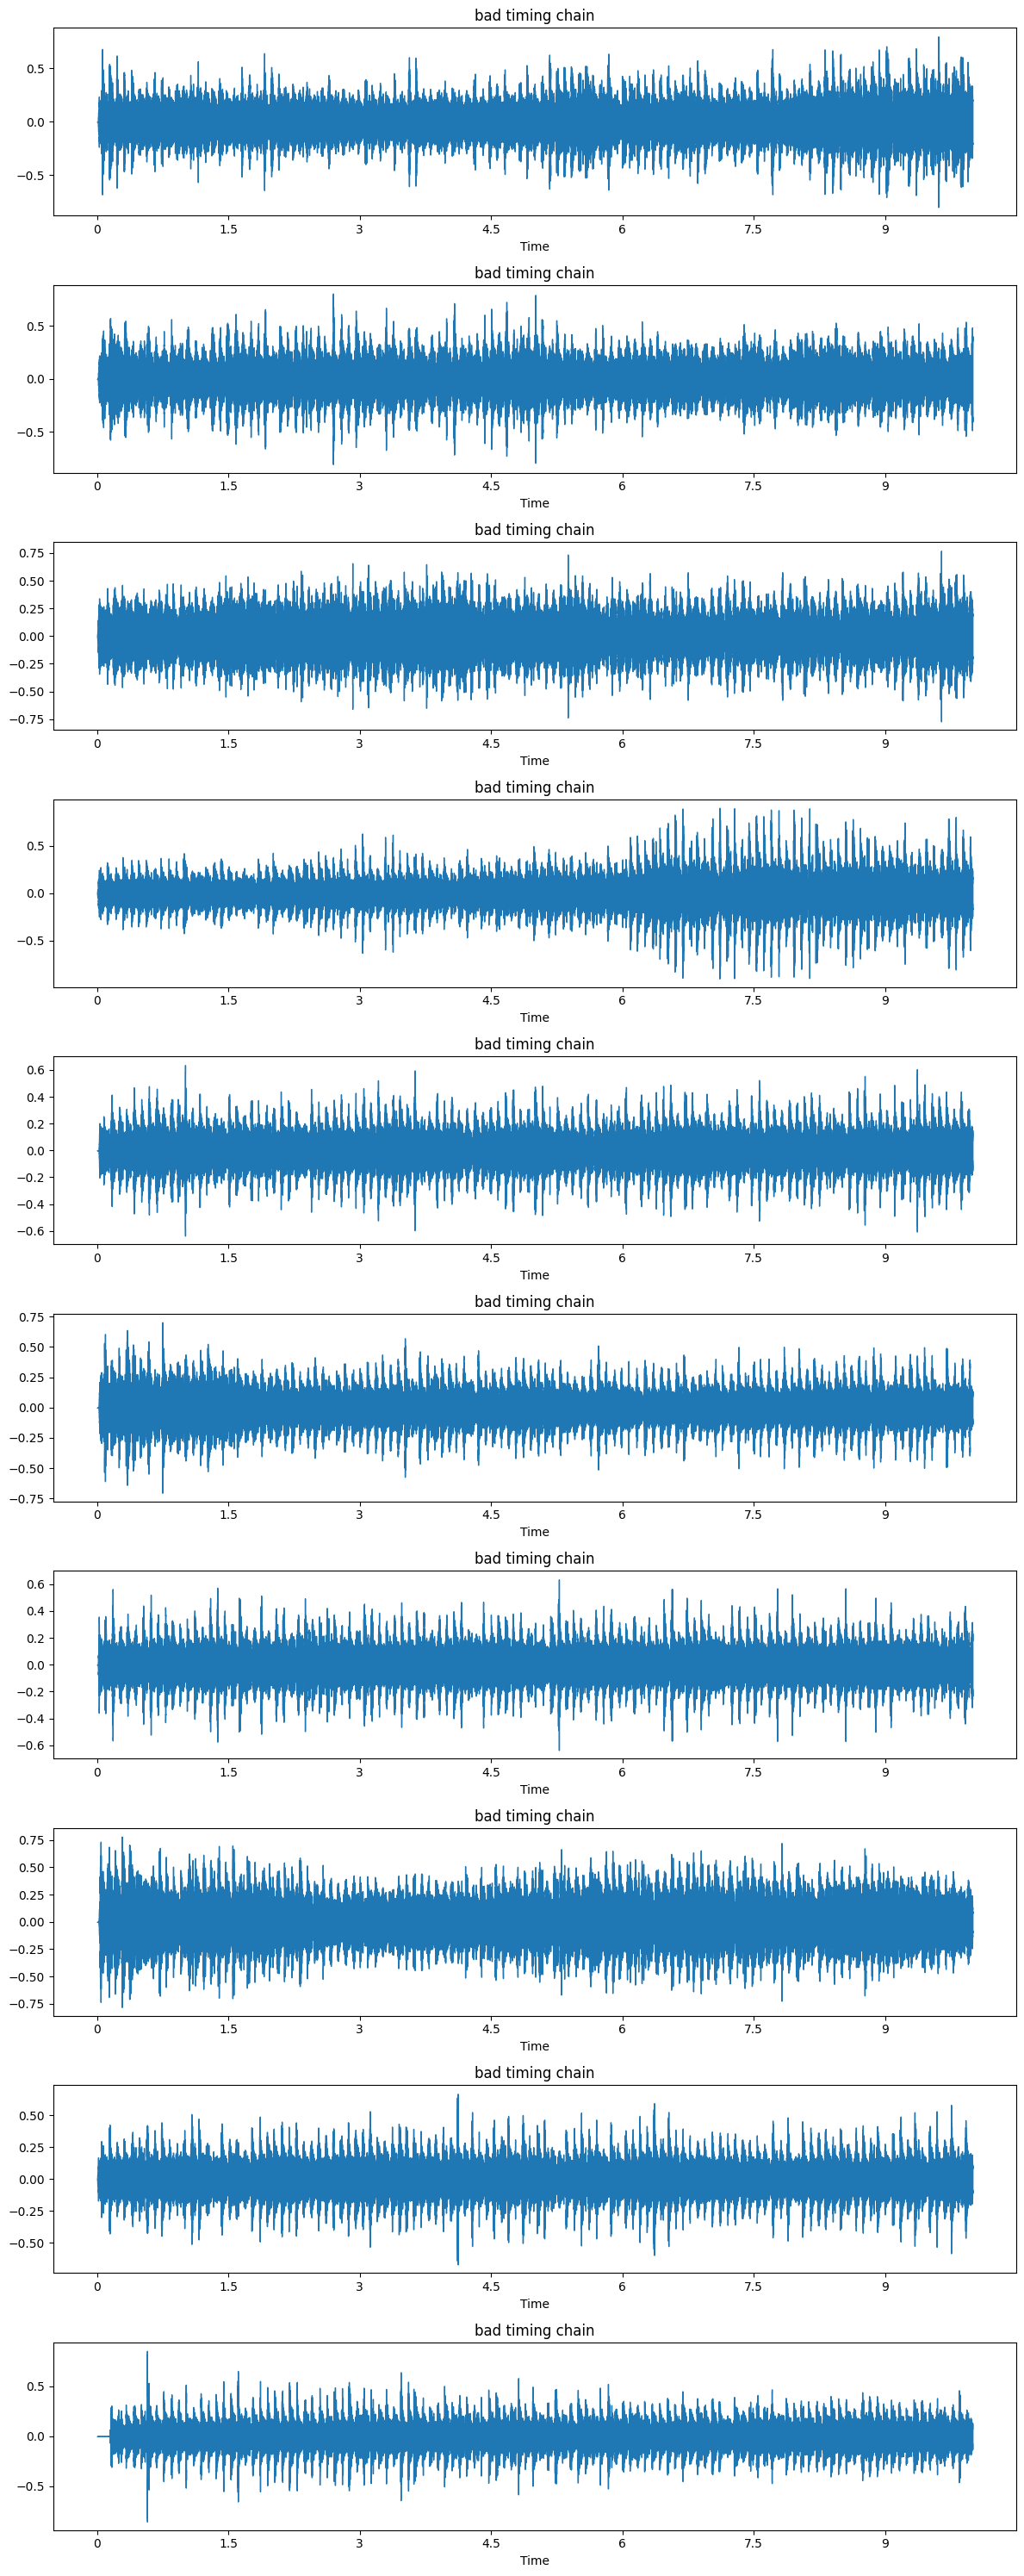

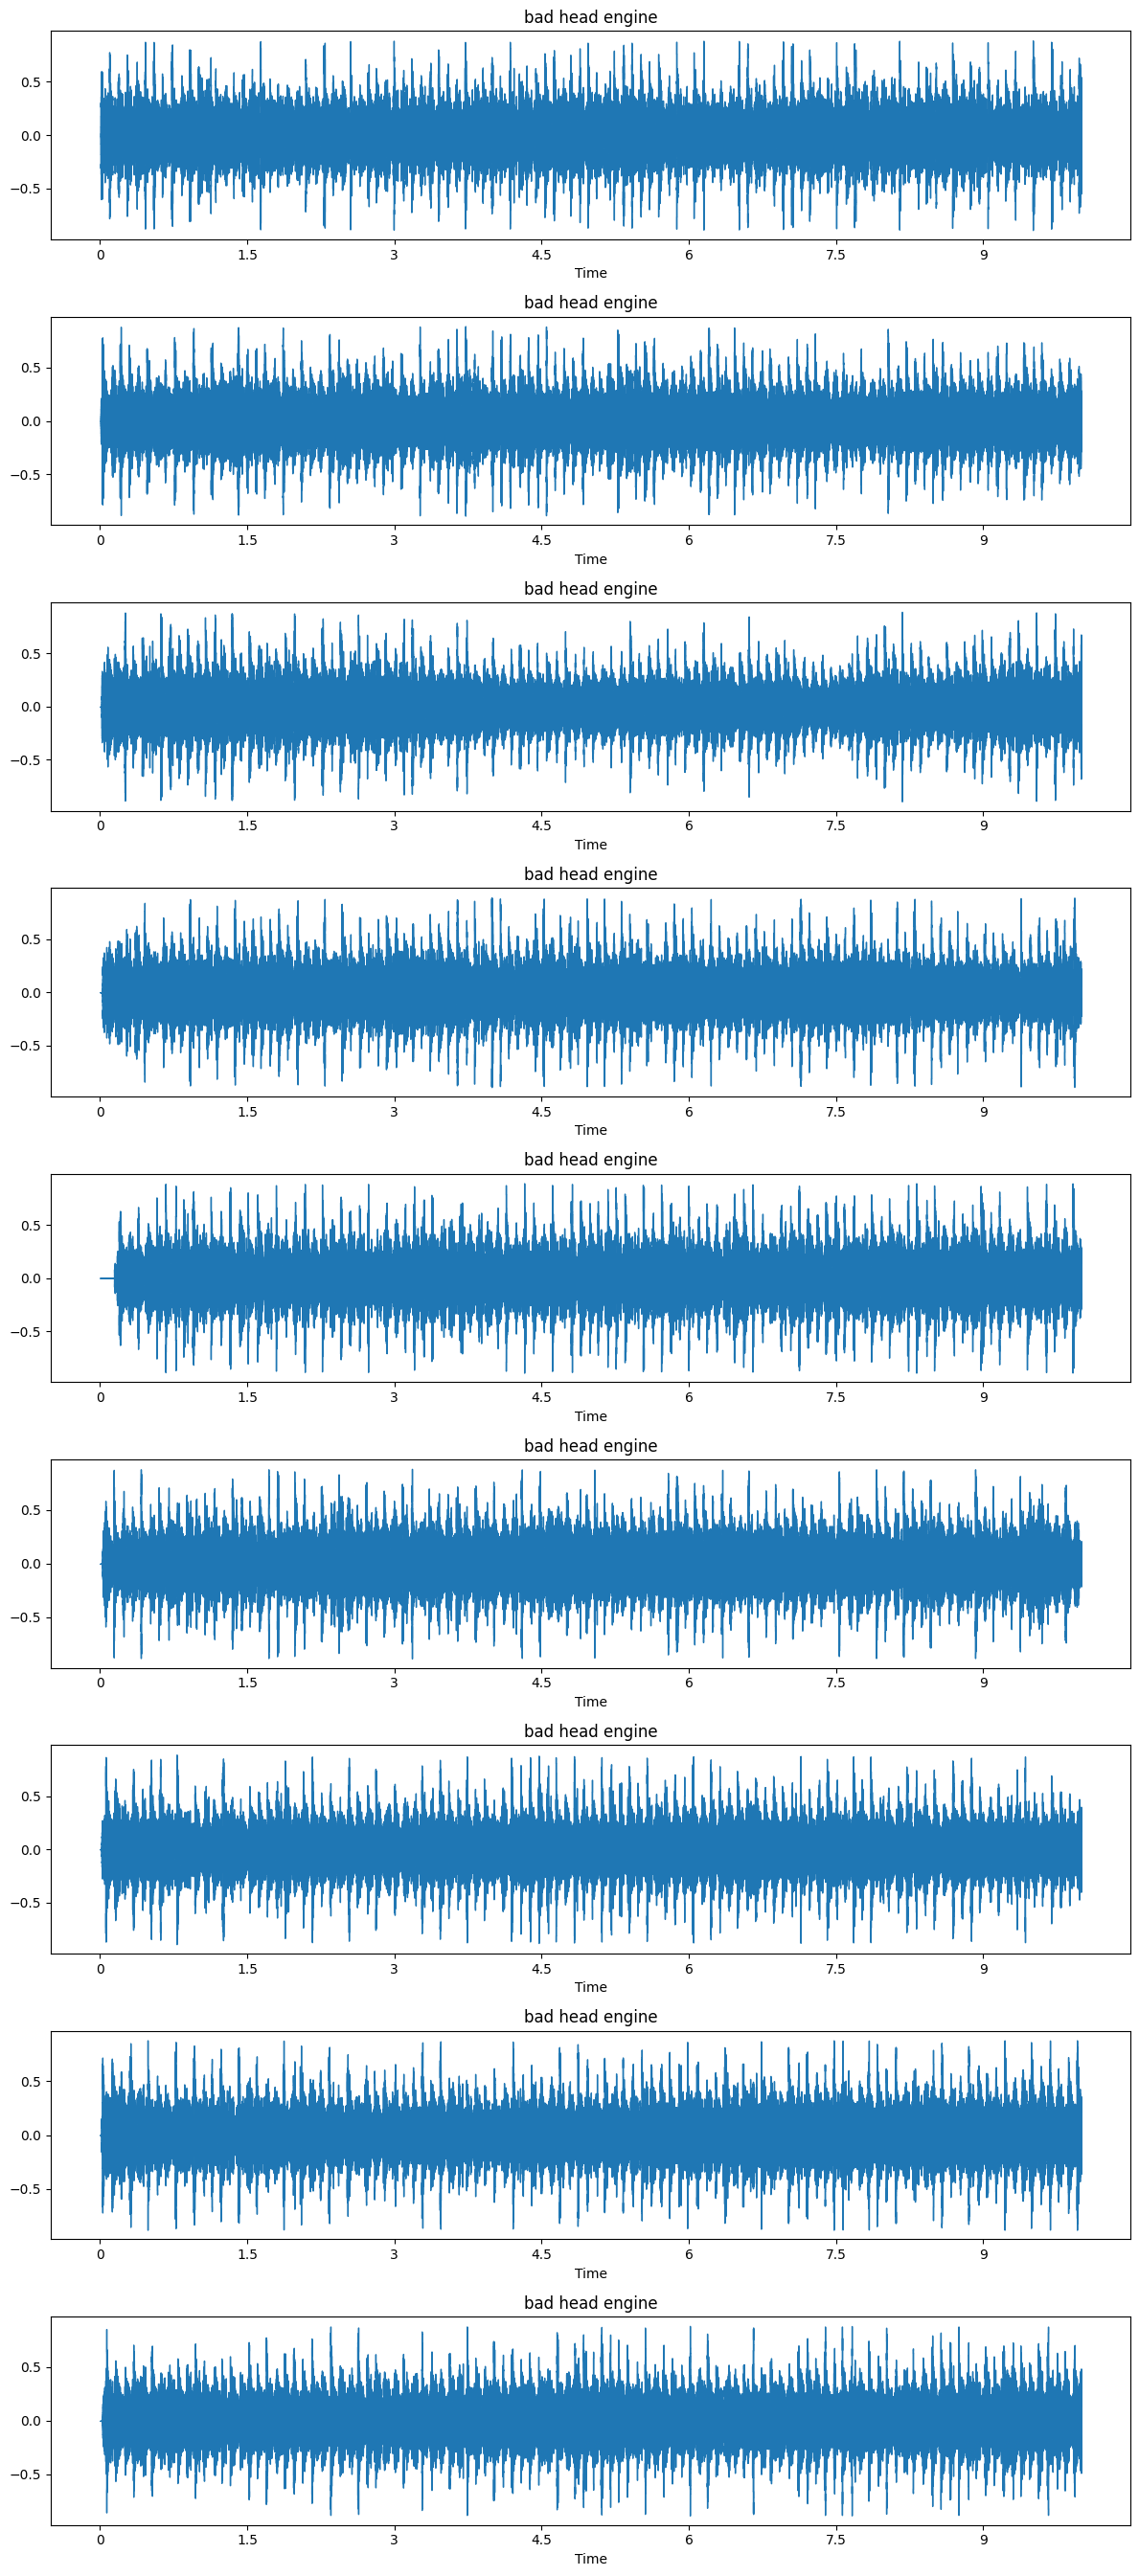

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Function to plot waveform of a given audio file
def plot_waveform(file_path, ax):
    y, sr = librosa.load(file_path, sr=None)
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.set_title(Path(file_path).parent.name)

# Visualize a few samples from each folder
def visualize_samples(audio_dir, samples_per_class=2):
    folders = os.listdir(audio_dir)
    for folder in folders:
        folder_path = Path(audio_dir) / folder
        files = list(folder_path.glob("*.wav"))
        files = random.sample(files, min(len(files), samples_per_class))

        plt.figure(figsize=(12, 3*len(files)))
        for i, file in enumerate(files):
            ax = plt.subplot(len(files), 1, i+1)
            plot_waveform(file, ax)
        plt.tight_layout()
        plt.show()

# Visualize GOOD audio
print("--- GOOD AUDIO ---")
visualize_samples(GOOD_DIR, samples_per_class=10)

# Visualize BAD audio
print("--- BAD AUDIO ---")
visualize_samples(BAD_DIR, samples_per_class=10)


In [ ]:
import os
from pathlib import Path

def count_files_in_dir(base_dir):
    print(f"\n--- Contents of {base_dir} ---")
    total_files = 0
    for folder in os.listdir(base_dir):
        folder_path = Path(base_dir) / folder
        if folder_path.is_dir():
            files = list(folder_path.glob("*.wav"))
            print(f"{folder}: {len(files)} files")
            total_files += len(files)
    print(f"Total files in {base_dir}: {total_files}")

# Count files in GOOD_DIR
count_files_in_dir(GOOD_DIR)

# Count files in BAD_DIR
count_files_in_dir(BAD_DIR)



--- Contents of /content/good_audio ---
head engine: 10 files
timing chain: 10 files
exhaust: 11 files
piston spark wav: 10 files
Total files in /content/good_audio: 41

--- Contents of /content/bad_audio ---
bad piston spark: 10 files
bad timing chain: 10 files
bad head engine: 9 files
bad engine exhaust: 9 files
Total files in /content/bad_audio: 38


In [ ]:
import os
from pathlib import Path
from collections import Counter

# Directories
GOOD_DIR = "/content/good_audio"
BAD_DIR = "/content/bad_audio"

def strict_train_test_split(base_dir, classes_to_use=4):
    train_files = []
    test_files = []

    for folder in os.listdir(base_dir):
        folder_path = Path(base_dir) / folder
        if folder_path.is_dir():
            files = sorted(list(folder_path.glob("*.wav")))[:classes_to_use*2]  # max 8 files
            train_files.extend(files[:classes_to_use])
            test_files.extend(files[classes_to_use:classes_to_use*2])

    return train_files, test_files

# Split GOOD_DIR and BAD_DIR
good_train, good_test = strict_train_test_split(GOOD_DIR, 4)
bad_train, bad_test = strict_train_test_split(BAD_DIR, 4)

# Combine
train_files = good_train + bad_train
test_files = good_test + bad_test

print("Training samples:", len(train_files))  # should be 32
print("Testing samples:", len(test_files))    # should be 32

# Check distribution
label_map = {
    "timing chain": 0,
    "piston spark wav": 1,
    "head engine": 2,
    "exhaust": 3,
    "bad timing chain": 4,
    "bad piston spark": 5,
    "bad head engine": 6,
    "bad engine exhaust": 7,
}

def show_class_distribution(file_list):
    counter = Counter()
    for f in file_list:
        folder_name = f.parent.name.lower()
        for key in label_map.keys():
            if key in folder_name:
                counter[key] += 1
    return counter

print("\nTrain distribution:", show_class_distribution(train_files))
print("Test distribution:", show_class_distribution(test_files))


Training samples: 32
Testing samples: 32

Train distribution: Counter({'head engine': 8, 'timing chain': 8, 'exhaust': 8, 'piston spark wav': 4, 'bad piston spark': 4, 'bad timing chain': 4, 'bad head engine': 4, 'bad engine exhaust': 4})
Test distribution: Counter({'head engine': 8, 'timing chain': 8, 'exhaust': 8, 'piston spark wav': 4, 'bad piston spark': 4, 'bad timing chain': 4, 'bad head engine': 4, 'bad engine exhaust': 4})



--- TRAINING FILES ---
head engine (4 files):
  /content/good_audio/head engine/head-engine_0r8tm89W.wav
  /content/good_audio/head engine/head-engine_5WvFSi2G.wav
  /content/good_audio/head engine/head-engine_8lZhdGKS.wav
  /content/good_audio/head engine/head-engine_BVakRU2Q.wav
timing chain (4 files):
  /content/good_audio/timing chain/timing-chain-100-10-sec_4VJKhjiM.wav
  /content/good_audio/timing chain/timing-chain-100-10-sec_BnQDdnJY.wav
  /content/good_audio/timing chain/timing-chain-100-10-sec_Fy9BkFZC.wav
  /content/good_audio/timing chain/timing-chain-100-10-sec_FyXDxBWm.wav
exhaust (4 files):
  /content/good_audio/exhaust/exaust_EpWBDWfK.wav
  /content/good_audio/exhaust/exaust_HqFJOu3A.wav
  /content/good_audio/exhaust/exaust_LS6LLBCi.wav
  /content/good_audio/exhaust/exaust_NcHsrOQR.wav
piston spark wav (4 files):
  /content/good_audio/piston spark wav/12_qmiQCbcc.wav
  /content/good_audio/piston spark wav/13_7mJmf3IR.wav
  /content/good_audio/piston spark wav/14_umxFB0

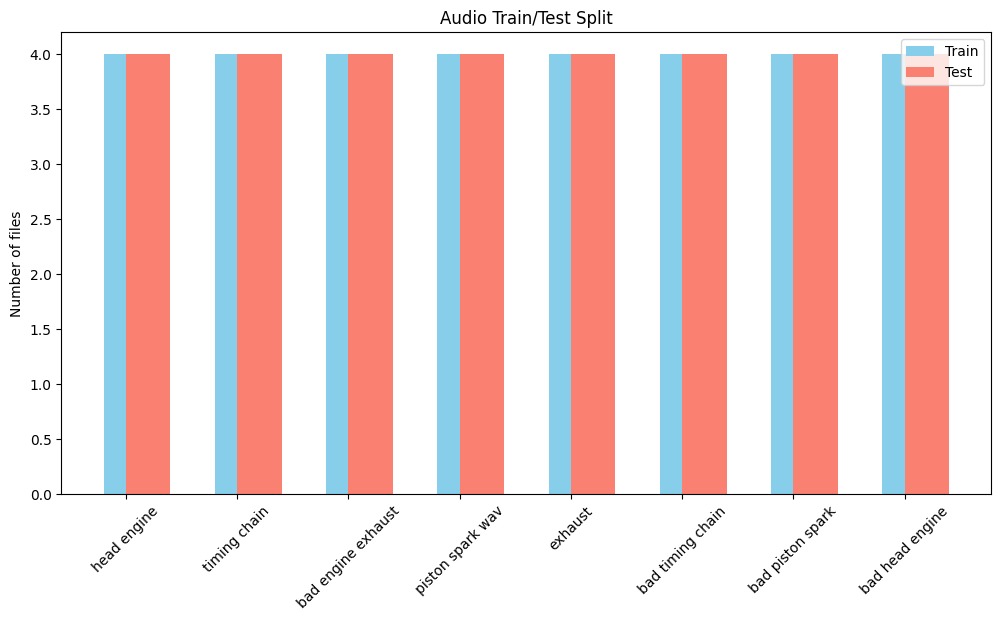

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Suppose you already have your train/test splits
# Example:
# good_train, good_test, bad_train, bad_test

def show_files_distribution(train_files, test_files, title="Dataset Distribution"):
    # Collect files by class
    train_dict = defaultdict(list)
    test_dict = defaultdict(list)

    for path in train_files:
        class_name = Path(path).parent.name
        train_dict[class_name].append(path)

    for path in test_files:
        class_name = Path(path).parent.name
        test_dict[class_name].append(path)

    # Print files
    print("\n--- TRAINING FILES ---")
    for cls, files in train_dict.items():
        print(f"{cls} ({len(files)} files):")
        for f in files:
            print(f"  {f}")

    print("\n--- TESTING FILES ---")
    for cls, files in test_dict.items():
        print(f"{cls} ({len(files)} files):")
        for f in files:
            print(f"  {f}")

    # Visualization: number of files per class
    classes = list(set(list(train_dict.keys()) + list(test_dict.keys())))
    train_counts = [len(train_dict[cls]) for cls in classes]
    test_counts = [len(test_dict[cls]) for cls in classes]

    x = range(len(classes))
    plt.figure(figsize=(12,6))
    plt.bar(x, train_counts, width=0.4, label='Train', color='skyblue', align='center')
    plt.bar(x, test_counts, width=0.4, label='Test', color='salmon', align='edge')
    plt.xticks(x, classes, rotation=45)
    plt.ylabel("Number of files")
    plt.title(title)
    plt.legend()
    plt.show()

# Call function
show_files_distribution(good_train + bad_train, good_test + bad_test, title="Audio Train/Test Split")


In [ ]:
import numpy as np
from collections import Counter
from pathlib import Path

# Define label map
label_map = {
    "timing chain": 0,
    "piston spark wav": 1,
    "head engine": 2,
    "exhaust": 3,
    "bad timing chain": 4,
    "bad piston spark": 5,
    "bad head engine": 6,
    "bad engine exhaust": 7,
}

def process_files(file_list):
    """
    Preprocess audio files and extract features.
    Returns features, labels, and file paths.
    """
    X, y, paths, ignored = [], [], [], []

    for path in file_list:
        # Preprocess audio and extract features
        audio = preprocess_audio(path)
        feats = extract_features(audio)

        folder_name = Path(path).parent.name.lower().replace(" ", "")
        matched = False

        for key, label in label_map.items():
            key_clean = key.replace(" ", "").lower()
            if key_clean in folder_name:
                X.append(feats)
                y.append(label)
                paths.append(str(path))
                matched = True
                break

        if not matched:
            ignored.append(str(path))

    X = np.array(X)
    y = np.array(y)
    return X, y, paths, ignored

# --- TRAINING FILES ---
train_files = [
    # GOOD_DIR
    "/content/good_audio/piston spark wav/12_qmiQCbcc.wav",
    "/content/good_audio/piston spark wav/13_7mJmf3IR.wav",
    "/content/good_audio/piston spark wav/14_umxFB0ps.wav",
    "/content/good_audio/piston spark wav/15_hRecSA6A.wav",
    "/content/good_audio/head engine/head-engine_0r8tm89W.wav",
    "/content/good_audio/head engine/head-engine_5WvFSi2G.wav",
    "/content/good_audio/head engine/head-engine_8lZhdGKS.wav",
    "/content/good_audio/head engine/head-engine_BVakRU2Q.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_4VJKhjiM.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_BnQDdnJY.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_Fy9BkFZC.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_FyXDxBWm.wav",
    "/content/good_audio/exhaust/exaust_EpWBDWfK.wav",
    "/content/good_audio/exhaust/exaust_HqFJOu3A.wav",
    "/content/good_audio/exhaust/exaust_LS6LLBCi.wav",
    "/content/good_audio/exhaust/exaust_NcHsrOQR.wav",
    # BAD_DIR
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_4buzKfJP.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_6EPcapR2.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_71Y7zpUO.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_IG2I0A7N.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_0YfxSBta.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_B0NiAgpb.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_JbuHDafx.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_N3WvYOLE.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_GOlwCTTe.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_JeFBP9AJ.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_UBTrhofi.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_cmIJeyGm.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_L3zsSseH.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_LwN1m16f.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_bEmiUOoA.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_iukbjUK3.wav"
]

# --- TESTING FILES ---
test_files = [
    # GOOD_DIR
    "/content/good_audio/piston spark wav/16_ZA5DmiEx.wav",
    "/content/good_audio/piston spark wav/17_hVLs0vYW.wav",
    "/content/good_audio/piston spark wav/18_l1aLPUYm.wav",
    "/content/good_audio/piston spark wav/19_ThR3YlMS.wav",
    "/content/good_audio/head engine/head-engine_CwELigpz.wav",
    "/content/good_audio/head engine/head-engine_Gq2vkiFm.wav",
    "/content/good_audio/head engine/head-engine_KZBc5KQY.wav",
    "/content/good_audio/head engine/head-engine_VZwVw9hS.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_Lof8Bul5.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_Vt9OklHh.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_XIyUNAkN.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_c97LRRlO.wav",
    "/content/good_audio/exhaust/exaust_QmTvtJk9.wav",
    "/content/good_audio/exhaust/exaust_RyZUyNvC.wav",
    "/content/good_audio/exhaust/exaust_XGXgwIH7.wav",
    "/content/good_audio/exhaust/exaust_aDERb51F.wav",
    # BAD_DIR
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_L7nuj23l.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_RAgwuLSP.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_RmNzwvR0.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_Z91U0yzH.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_WKjiMopb.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_Y6860heO.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_fPoKg9ZM.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_hfJt3rIw.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_k4UjNKnr.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_lrrqdji4.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_wUXwYsbz.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_wzH4WpHW.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_meWdY8gg.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_wWBLO732.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_wxj6qKTD.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_xJhyGdb8.wav"
]

# --- Process TRAIN and TEST ---
X_train, y_train, train_paths, ignored_train = process_files(train_files)
X_test, y_test, test_paths, ignored_test = process_files(test_files)

# --- Print info ---
from collections import Counter

print("Training features shape:", X_train.shape)
print("Training labels distribution:", Counter(y_train))
print("Ignored training files:", ignored_train)

print("Testing features shape:", X_test.shape)
print("Testing labels distribution:", Counter(y_test))
print("Ignored testing files:", ignored_test)


Training features shape: (32, 334)
Training labels distribution: Counter({np.int64(2): 8, np.int64(0): 8, np.int64(3): 8, np.int64(1): 4, np.int64(5): 4})
Ignored training files: []
Testing features shape: (32, 334)
Testing labels distribution: Counter({np.int64(2): 8, np.int64(0): 8, np.int64(3): 8, np.int64(1): 4, np.int64(5): 4})
Ignored testing files: []


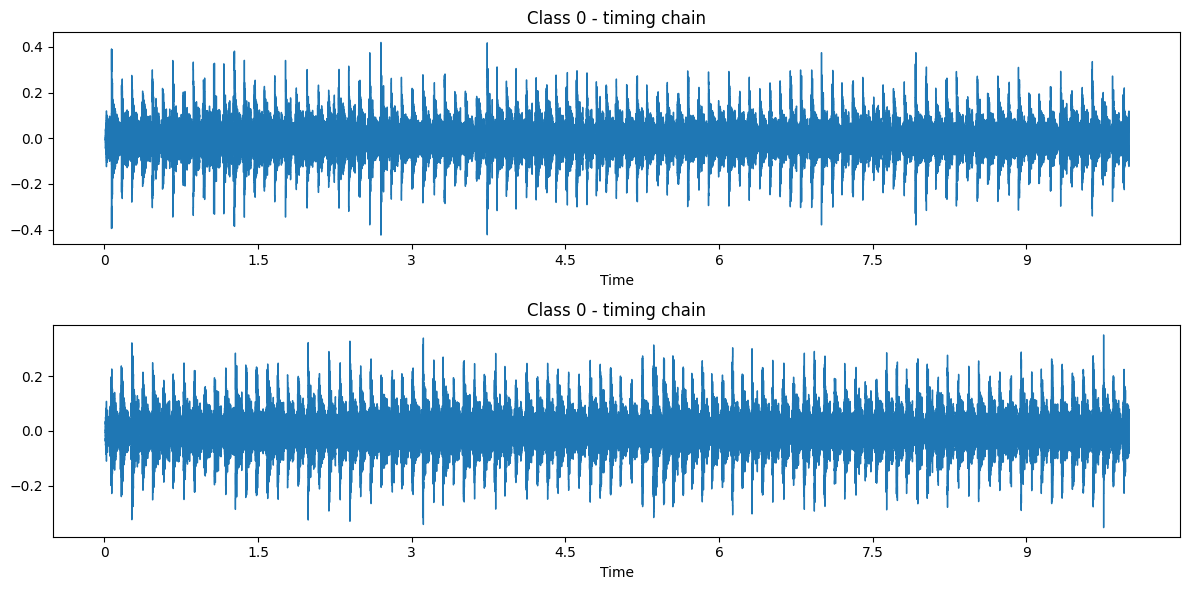

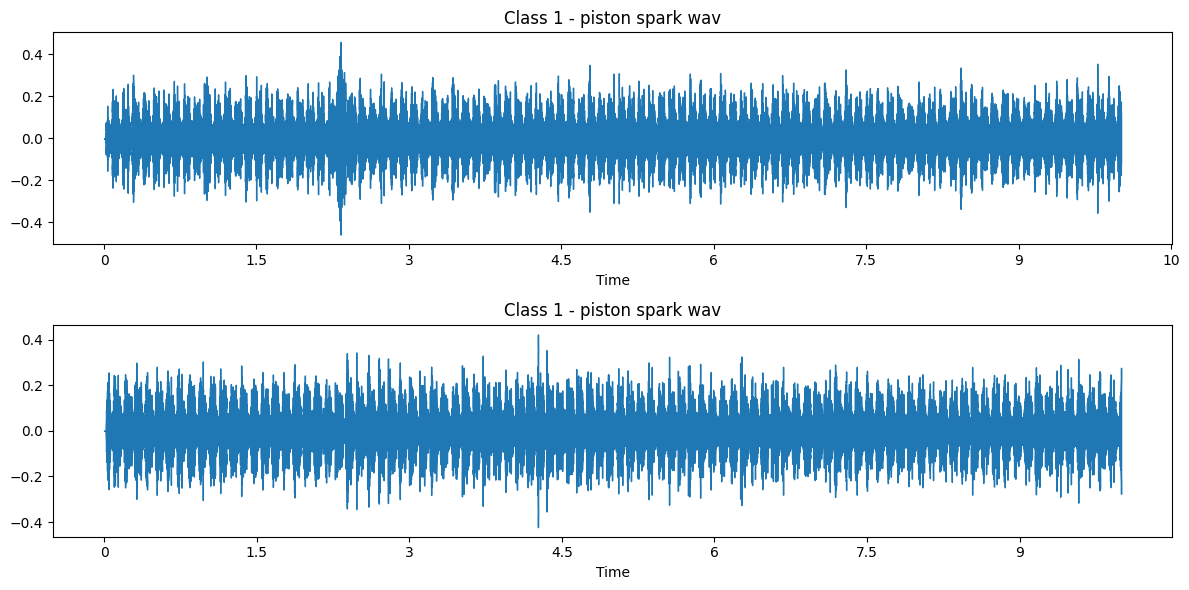

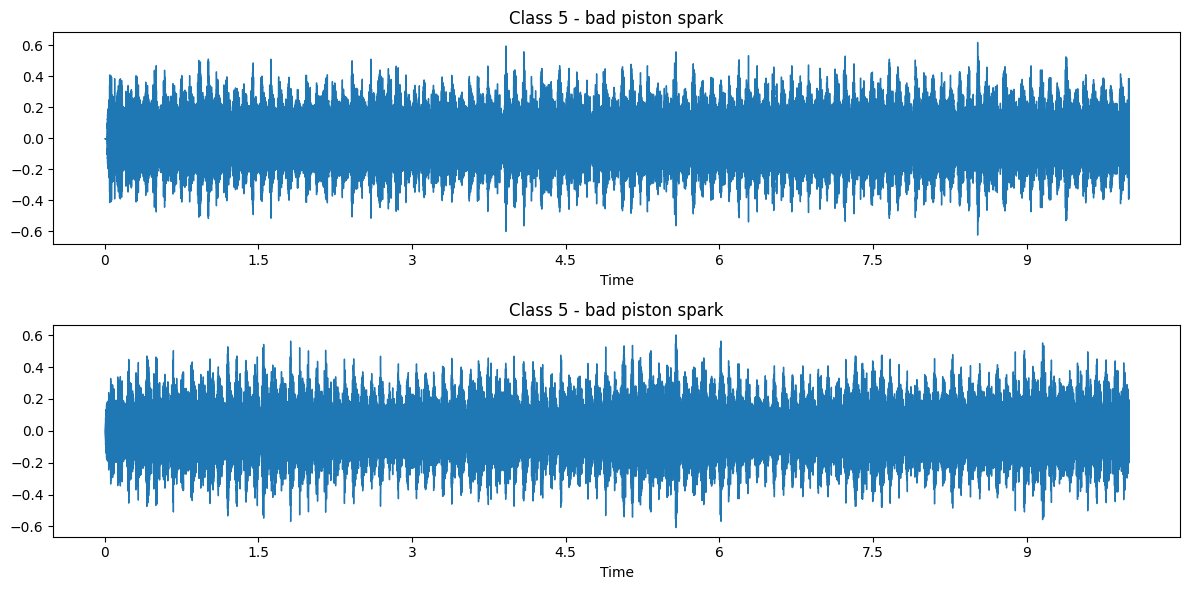

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

def plot_waveforms(file_paths, labels, num_samples=2):
    """
    Plots waveforms of audio files per class.
    """
    unique_labels = np.unique(labels)

    for label in unique_labels:
        label_files = [file_paths[i] for i in range(len(labels)) if labels[i] == label]
        plt.figure(figsize=(12, 3 * num_samples))
        for i, fpath in enumerate(label_files[:num_samples]):
            audio, sr = librosa.load(fpath, sr=None)
            plt.subplot(num_samples, 1, i+1)
            librosa.display.waveshow(audio, sr=sr)
            plt.title(f"Class {label} - {Path(fpath).parent.name}")
        plt.tight_layout()
        plt.show()

# Example: visualize 2 samples per class from training set
plot_waveforms(train_paths, y_train, num_samples=2)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Initialize classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on training data
clf.fit(X_train, y_train)

# Predict on testing data
y_pred = clf.predict(X_test)

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Confusion Matrix:
 [[7 0 1 0 0]
 [0 4 0 0 0]
 [0 0 8 0 0]
 [0 0 0 8 0]
 [0 0 0 0 4]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00         4
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.98      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



In [ ]:
import librosa
import numpy as np

def extract_advanced_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Chroma
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # Mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_mean = np.mean(mel, axis=1)

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
    contrast_mean = np.mean(contrast, axis=1)

    # Tonnetz
    y_harmonic = librosa.effects.harmonic(y)
    tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    tonnetz_mean = np.mean(tonnetz, axis=1)

    # Combine all features
    features = np.concatenate([mfcc_mean, chroma_mean, mel_mean, contrast_mean, tonnetz_mean])

    return features


In [ ]:
X_train_new = []
y_train_new = []

# Use the correct variables
for path, label in zip(train_paths, y_train):
    feats = extract_advanced_features(path)
    X_train_new.append(feats)
    y_train_new.append(label)

X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

print("Training features shape after feature engineering:", X_train_new.shape)


Training features shape after feature engineering: (32, 166)


In [ ]:
X_test_new = []
y_test_new = []

for path, label in zip(test_paths, y_test):
    feats = extract_advanced_features(path)
    X_test_new.append(feats)
    y_test_new.append(label)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print("Testing features shape after feature engineering:", X_test_new.shape)


Testing features shape after feature engineering: (32, 166)


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Number of samples to visualize
num_samples = 8

plt.figure(figsize=(15, 10))

for i, (path, label) in enumerate(zip(train_paths[:num_samples], y_train[:num_samples])):
    audio, sr = librosa.load(path, sr=None)  # Load audio
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to dB

    plt.subplot(2, 4, i+1)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Label: {label}")

plt.tight_layout()
plt.show()


In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# Parameters
IMG_HEIGHT = 128  # Mel bands
IMG_WIDTH = 128   # Time steps (resize spectrogram)
NUM_CLASSES = len(np.unique(y_train))

# Function to convert audio to Mel spectrogram image
def audio_to_melspectrogram(path, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
    audio, sr = librosa.load(path, sr=None)
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=img_height)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Resize to fixed width
    if S_dB.shape[1] < img_width:
        pad_width = img_width - S_dB.shape[1]
        S_dB = np.pad(S_dB, ((0,0),(0,pad_width)), mode='constant')
    else:
        S_dB = S_dB[:, :img_width]

    return S_dB

# Prepare training data
X_train_img = np.array([audio_to_melspectrogram(p) for p in train_paths])
X_train_img = X_train_img[..., np.newaxis]  # Add channel
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)

# Same for testing
X_test_img = np.array([audio_to_melspectrogram(p) for p in test_paths])
X_test_img = X_test_img[..., np.newaxis]
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)

# Build CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(X_train_img, y_train_cat, validation_data=(X_test_img, y_test_cat),
                    epochs=50, batch_size=8)


IndexError: index 5 is out of bounds for axis 1 with size 5

In [ ]:
NUM_CLASSES = max(y_train) + 1  # ensures it covers the largest label
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat  = to_categorical(y_test, num_classes=NUM_CLASSES)


In [ ]:
# Cell 0: setup, file lists, basic audio helpers
import os
import math
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter, defaultdict

import librosa
import librosa.display
import matplotlib.pyplot as plt

# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# Gradio for UI at the end
import gradio as gr

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Label map (as you provided)
label_map = {
    "timing chain": 0,
    "piston spark wav": 1,
    "head engine": 2,
    "exhaust": 3,
    "bad timing chain": 4,
    "bad piston spark": 5,
    "bad head engine": 6,
    "bad engine exhaust": 7,
}
inv_label_map = {v: k for k, v in label_map.items()}

# === Your train/test split (re-use your lists) ===
train_files = [
    # (include the 32 training paths you provided earlier)
    "/content/good_audio/piston spark wav/12_qmiQCbcc.wav",
    "/content/good_audio/piston spark wav/13_7mJmf3IR.wav",
    "/content/good_audio/piston spark wav/14_umxFB0ps.wav",
    "/content/good_audio/piston spark wav/15_hRecSA6A.wav",
    "/content/good_audio/head engine/head-engine_0r8tm89W.wav",
    "/content/good_audio/head engine/head-engine_5WvFSi2G.wav",
    "/content/good_audio/head engine/head-engine_8lZhdGKS.wav",
    "/content/good_audio/head engine/head-engine_BVakRU2Q.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_4VJKhjiM.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_BnQDdnJY.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_Fy9BkFZC.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_FyXDxBWm.wav",
    "/content/good_audio/exhaust/exaust_EpWBDWfK.wav",
    "/content/good_audio/exhaust/exaust_HqFJOu3A.wav",
    "/content/good_audio/exhaust/exaust_LS6LLBCi.wav",
    "/content/good_audio/exhaust/exaust_NcHsrOQR.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_4buzKfJP.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_6EPcapR2.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_71Y7zpUO.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_IG2I0A7N.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_0YfxSBta.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_B0NiAgpb.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_JbuHDafx.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_N3WvYOLE.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_GOlwCTTe.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_JeFBP9AJ.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_UBTrhofi.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_cmIJeyGm.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_L3zsSseH.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_LwN1m16f.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_bEmiUOoA.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_iukbjUK3.wav",
]

test_files = [
    # (include the 32 testing paths you provided earlier)
    "/content/good_audio/piston spark wav/16_ZA5DmiEx.wav",
    "/content/good_audio/piston spark wav/17_hVLs0vYW.wav",
    "/content/good_audio/piston spark wav/18_l1aLPUYm.wav",
    "/content/good_audio/piston spark wav/19_ThR3YlMS.wav",
    "/content/good_audio/head engine/head-engine_CwELigpz.wav",
    "/content/good_audio/head engine/head-engine_Gq2vkiFm.wav",
    "/content/good_audio/head engine/head-engine_KZBc5KQY.wav",
    "/content/good_audio/head engine/head-engine_VZwVw9hS.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_Lof8Bul5.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_Vt9OklHh.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_XIyUNAkN.wav",
    "/content/good_audio/timing chain/timing-chain-100-10-sec_c97LRRlO.wav",
    "/content/good_audio/exhaust/exaust_QmTvtJk9.wav",
    "/content/good_audio/exhaust/exaust_RyZUyNvC.wav",
    "/content/good_audio/exhaust/exaust_XGXgwIH7.wav",
    "/content/good_audio/exhaust/exaust_aDERb51F.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_L7nuj23l.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_RAgwuLSP.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_RmNzwvR0.wav",
    "/content/bad_audio/bad piston spark/piston-spark-bad-engine_Z91U0yzH.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_WKjiMopb.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_Y6860heO.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_fPoKg9ZM.wav",
    "/content/bad_audio/bad timing chain/timing-chain-bad-engine_hfJt3rIw.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_k4UjNKnr.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_lrrqdji4.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_wUXwYsbz.wav",
    "/content/bad_audio/bad head engine/head-engine-bad-engine_wzH4WpHW.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_meWdY8gg.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_wWBLO732.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_wxj6qKTD.wav",
    "/content/bad_audio/bad engine exhaust/exaust-bad-engine_xJhyGdb8.wav",
]

# Audio constants for windowing / features
SR = 22050            # target sampling rate
WINDOW_SEC = 2.0      # window length in seconds
HOP_SEC = 1.0         # hop between windows (overlap)
WINDOW_SAMPLES = int(WINDOW_SEC * SR)
HOP_SAMPLES = int(HOP_SEC * SR)

# Audio preprocess: load, trim/pad to at least one window
def preprocess_audio_for_windowing(path, sr=SR, min_seconds=2.0):
    y, _ = librosa.load(path, sr=sr)
    # if too short, pad
    if len(y) < int(min_seconds * sr):
        pad_len = int(min_seconds * sr) - len(y)
        y = np.pad(y, (0, pad_len), mode='constant')
    return y

# Windowing function -> returns list of windows (numpy arrays)
def window_audio_array(y, sr=SR, window_samples=WINDOW_SAMPLES, hop_samples=HOP_SAMPLES):
    windows = []
    i = 0
    while i + window_samples <= len(y):
        win = y[i:i+window_samples]
        windows.append(win)
        i += hop_samples
    # if last leftover smaller than full window, you may optionally pad and include:
    if i < len(y):
        last = y[-window_samples:]
        windows.append(last)
    return windows

# quick helper to map folder to integer label robustly
def folder_to_label(path):
    folder_name = Path(path).parent.name.lower()
    # exact match of keys ignoring spacing/hyphen
    clean = folder_name.replace(" ", "").replace("-", "")
    for k, v in label_map.items():
        if k.replace(" ", "").replace("-", "") == clean:
            return v
    # fallback: substring match
    for k, v in label_map.items():
        if k.replace(" ", "").lower() in folder_name:
            return v
    raise ValueError(f"Unknown folder name for path: {path}")


Total training windows: 320
Window label distribution: Counter({1: 40, 2: 40, 0: 40, 3: 40, 5: 40, 4: 40, 6: 40, 7: 40})


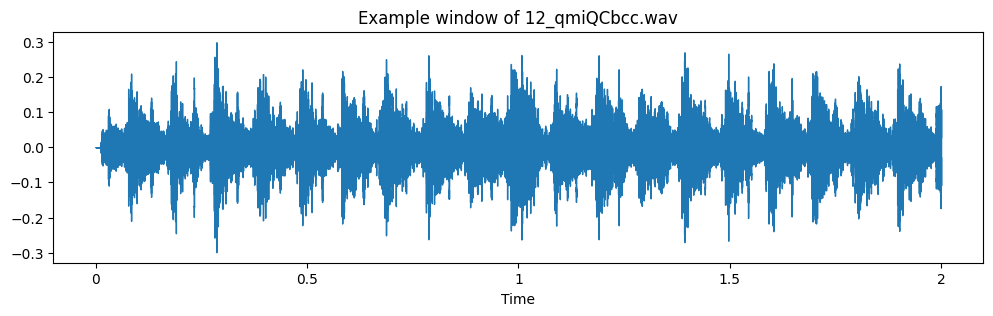

In [ ]:
# Cell 1: create windowed dataset from training audio
train_windows = []   # list of arrays
train_labels = []    # per-window label (int)
train_parent_file = []  # which original file this window came from

for p in train_files:
    y = preprocess_audio_for_windowing(p, sr=SR, min_seconds=WINDOW_SEC)
    wins = window_audio_array(y, sr=SR, window_samples=WINDOW_SAMPLES, hop_samples=HOP_SAMPLES)
    lbl = folder_to_label(p)
    for w in wins:
        train_windows.append(w)
        train_labels.append(lbl)
        train_parent_file.append(p)

print("Total training windows:", len(train_windows))
print("Window label distribution:", Counter(train_labels))
# quick sanity plot for first file's windows
plt.figure(figsize=(12,3))
librosa.display.waveshow(train_windows[0], sr=SR)
plt.title(f"Example window of {Path(train_parent_file[0]).name}")
plt.show()


In [ ]:
# Cell 2: extract many features per window and build DataFrame
def extract_window_features(y, sr=SR, n_mfcc=13, hop_length=512):
    # ensure float32
    y = np.array(y, dtype=float)
    feats = {}
    # MFCCs (mean & std)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    feats.update({f"mfcc_mean_{i+1}": np.mean(mfcc[i]) for i in range(n_mfcc)})
    feats.update({f"mfcc_std_{i+1}": np.std(mfcc[i]) for i in range(n_mfcc)})
    # delta MFCCs
    d_mfcc = librosa.feature.delta(mfcc)
    feats.update({f"dmfcc_mean_{i+1}": np.mean(d_mfcc[i]) for i in range(n_mfcc)})
    feats.update({f"dmfcc_std_{i+1}": np.std(d_mfcc[i]) for i in range(n_mfcc)})
    # Chroma
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    feats.update({f"chroma_mean_{i+1}": np.mean(chroma[i]) for i in range(chroma.shape[0])})
    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
    feats.update({f"contrast_mean_{i+1}": np.mean(contrast[i]) for i in range(contrast.shape[0])})
    # Tonnetz (requires harmonic)
    y_harm = librosa.effects.harmonic(y)
    try:
        tonnetz = librosa.feature.tonnetz(y=y_harm, sr=sr)
        feats.update({f"tonnetz_mean_{i+1}": np.mean(tonnetz[i]) for i in range(tonnetz.shape[0])})
    except Exception:
        # if tonnetz fails, fill zeros
        feats.update({f"tonnetz_mean_{i+1}": 0.0 for i in range(6)})
    # spectral rolloff, centroid, bandwidth, zcr, rms
    feats["zcr_mean"] = np.mean(librosa.feature.zero_crossing_rate(y))
    feats["centroid_mean"] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    feats["rolloff_mean"] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    feats["bandwidth_mean"] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    feats["rms_mean"] = np.mean(librosa.feature.rms(y=y))
    return feats

# Build DataFrame
rows = []
for w, lbl, p in zip(train_windows, train_labels, train_parent_file):
    feats = extract_window_features(w, sr=SR)
    feats["label"] = lbl
    feats["source_file"] = p
    rows.append(feats)

df_train = pd.DataFrame(rows)
print("Feature table shape:", df_train.shape)
display(df_train.head())

# Basic cleaning: check NaNs and impute (very unlikely but safe)
print("NaN counts per column:", df_train.isna().sum().sum())
df_train.fillna(0, inplace=True)

# Feature matrix and label vector
X_train_raw = df_train.drop(columns=["label", "source_file"]).values
y_train_arr = df_train["label"].values

# Scaling (fit only on training)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)

# show feature statistics table (mean,std, min,max)
feat_stats = pd.DataFrame({
    "feature": df_train.drop(columns=["label","source_file"]).columns,
    "mean": np.mean(X_train_raw, axis=0),
    "std": np.std(X_train_raw, axis=0),
    "min": np.min(X_train_raw, axis=0),
    "max": np.max(X_train_raw, axis=0)
})
display(feat_stats.head(30))


/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


Feature table shape: (320, 84)


mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  mfcc_mean_4  mfcc_mean_5  \
0  -121.175017    58.491621   -42.493696    -7.813625    -3.339166   
1  -114.225316    58.314152   -40.594105    -9.080725    -3.473290   
2  -114.887800    61.901095   -40.832261    -9.761577    -3.362516   
3  -118.416239    65.048567   -42.674061    -8.994239    -3.845173   
4  -115.199501    64.323526   -42.782713    -8.420102    -4.820380   

   mfcc_mean_6  mfcc_mean_7  mfcc_mean_8  mfcc_mean_9  mfcc_mean_10  ...  \
0    -1.569372     8.438878   -10.515742     3.781912     -5.683346  ...   
1    -2.413799     9.415041    -9.501646     3.081905     -4.809962  ...   
2    -3.235979    10.013259    -9.363224     4.099297     -6.127503  ...   
3    -3.102578     9.603914   -10.255638     5.444868     -5.704010  ...   
4    -2.280961     9.802060    -9.842248     6.300626     -4.967796  ...   

   tonnetz_mean_4  tonnetz_mean_5  tonnetz_mean_6  zcr_mean  centroid_mean  \
0       -0.034434        0.012196       -0.020920  0.226759    3235.855785   
1       -0.022798        0.004685       -0.025903  0.232607    3284.303043   
2       -0.005202        0.005862       -0.027792  0.229178    3215.030440   
3       -0.025234        0.014545       -0.025549  0.210786    3098.245879   
4       -0.030278       -0.004373       -0.027308  0.204955    3092.999570   

   rolloff_mean  bandwidth_mean  rms_mean  label  \
0   6203.171303     2736.826549  0.046180      1   
1   6380.387089     2780.600237  0.048849      1   
2   6251.559133     2772.948126  0.048846      1   
3   5948.856748     2715.906111  0.046645      1   
4   5911.978044     2693.607800  0.048206      1   

                                         source_file  
0  /content/good_audio/piston spark wav/12_qmiQCb...  
1  /content/good_audio/piston spark wav/12_qmiQCb...  
2  /content/good_audio/piston spark wav/12_qmiQCb...  
3  /content/good_audio/piston spark wav/12_qmiQCb...  
4  /content/good_audio/piston spark wav/12_qmiQCb...  

[5 rows x 84 columns]

NaN counts per column: 0


feature       mean        std         min         max
0    mfcc_mean_1 -88.533165  39.141912 -158.703352  -18.182908
1    mfcc_mean_2  60.866321  17.623615   30.203650  102.349842
2    mfcc_mean_3 -40.659843  10.853927  -63.513352  -17.391661
3    mfcc_mean_4   3.826027   9.709082  -19.526781   38.196782
4    mfcc_mean_5  -1.473656   9.186998  -15.969365   18.964914
5    mfcc_mean_6  -4.701088  14.141143  -38.869195   25.889362
6    mfcc_mean_7  -0.498062  10.520219  -19.691671   25.178884
7    mfcc_mean_8  -4.544355   5.916130  -18.609208    8.798845
8    mfcc_mean_9   0.210292  11.678242  -23.489518   24.103777
9   mfcc_mean_10   7.188916   7.240615   -6.127503   20.367195
10  mfcc_mean_11 -10.637813   7.339850  -24.485918    4.880701
11  mfcc_mean_12   6.994775   5.543433   -4.984188   17.634204
12  mfcc_mean_13  -9.438532   6.125639  -20.977307    3.676107
13    mfcc_std_1  20.104394  13.922520   10.175498  153.934951
14    mfcc_std_2   6.651029   2.212226    3.742712   17.530176
15    mfcc_std_3  13.055263   2.378186    7.065176   18.937231
16    mfcc_std_4   5.802177   1.231113    3.967469   18.738620
17    mfcc_std_5   5.209507   1.113835    3.374912   11.240001
18    mfcc_std_6   5.328116   1.214724    3.272199   13.367443
19    mfcc_std_7   4.644617   0.731315    2.954458    7.121939
20    mfcc_std_8   4.825812   0.711377    2.908630    6.738875
21    mfcc_std_9   4.598746   0.830793    3.243889    7.055192
22   mfcc_std_10   5.014350   0.780229    3.603934    7.420502
23   mfcc_std_11   4.589891   0.611018    3.043224    7.065075
24   mfcc_std_12   4.282547   0.551580    3.029993    5.727657
25   mfcc_std_13   4.556271   0.699691    3.293650    6.823186
26  dmfcc_mean_1   0.136321   0.964133   -0.796185   10.153330
27  dmfcc_mean_2   0.024361   0.152179   -0.345791    1.073172
28  dmfcc_mean_3  -0.005658   0.175644   -0.770770    0.478238
29  dmfcc_mean_4  -0.005158   0.104649   -0.349000    0.463555

In [ ]:
# Cell 3: Train multiple ML models with Stratified K-Fold CV and show metrics
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=RANDOM_SEED),
    "SVM_rbf": SVC(kernel='rbf', probability=True, C=1.0),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=RANDOM_SEED),
    "LogisticL2": LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=1000)
}

scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro"
}

results = []
for name, model in models.items():
    print(f"Running CV for {name} ...")
    cv_res = cross_validate(model, X_train_scaled, y_train_arr, cv=skf, scoring=scoring, return_train_score=False)
    summary = {
        "model": name,
        "accuracy_mean": np.mean(cv_res["test_accuracy"]),
        "accuracy_std": np.std(cv_res["test_accuracy"]),
        "precision_mean": np.mean(cv_res["test_precision_macro"]),
        "recall_mean": np.mean(cv_res["test_recall_macro"]),
        "f1_mean": np.mean(cv_res["test_f1_macro"])
    }
    results.append(summary)

df_ml_results = pd.DataFrame(results).sort_values("f1_mean", ascending=False)
display(df_ml_results)


Running CV for RandomForest ...
Running CV for SVM_rbf ...
Running CV for GradientBoosting ...
Running CV for LogisticL2 ...


model  accuracy_mean  accuracy_std  precision_mean  recall_mean  \
0      RandomForest        1.00000      0.000000        1.000000      1.00000   
3        LogisticL2        1.00000      0.000000        1.000000      1.00000   
1           SVM_rbf        0.99375      0.007655        0.994444      0.99375   
2  GradientBoosting        0.96250      0.037760        0.967262      0.96250   

    f1_mean  
0  1.000000  
3  1.000000  
1  0.993725  
2  0.963029

In [ ]:
# Cell 4: fit the models on all training windows and save fitted estimators
fitted_models = {}
for name, model in models.items():
    print("Fitting:", name)
    model.fit(X_train_scaled, y_train_arr)
    fitted_models[name] = model

# For stacking super-classifier
stack_estimators = [
    ('rf', fitted_models['RandomForest']),
    ('gb', fitted_models['GradientBoosting']),
    ('svm', fitted_models['SVM_rbf']),
]
final_est = LogisticRegression(max_iter=1000)
stack_clf = StackingClassifier(estimators=stack_estimators, final_estimator=final_est, cv=5)
print("Fitting stacking classifier ...")
stack_clf.fit(X_train_scaled, y_train_arr)
fitted_models['Stacking'] = stack_clf

print("All classical models fitted.")


Fitting: RandomForest
Fitting: SVM_rbf
Fitting: GradientBoosting
Fitting: LogisticL2
Fitting stacking classifier ...
All classical models fitted.


In [ ]:
# Cell 5: Deep model (MLP) on features
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

num_features = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train_arr))

# Remap labels to consecutive [0..N-1] if needed (they may already be consecutive)
unique_labels = sorted(np.unique(y_train_arr))
label_map_consec = {lab: i for i, lab in enumerate(unique_labels)}
y_train_mapped = np.array([label_map_consec[l] for l in y_train_arr])

y_train_cat = tf.keras.utils.to_categorical(y_train_mapped, num_classes=len(unique_labels))

def build_mlp(input_dim, num_classes, l2=1e-4, dropout_rate=0.4):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=out) # Changed models.Model to tf.keras.Model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp = build_mlp(num_features, len(unique_labels))
mlp.summary()

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

history_mlp = mlp.fit(X_train_scaled, y_train_cat, validation_split=0.15, epochs=100, batch_size=8,
                      callbacks=[es, rlr], verbose=2)
# Evaluate on training (we will evaluate properly on windows -> file aggregation later)
train_loss, train_acc = mlp.evaluate(X_train_scaled, y_train_cat, verbose=0)
print("MLP training (on windows) accuracy:", train_acc)
fitted_models['MLP'] = (mlp, label_map_consec)  # save mapping too


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 82)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,712 (221.53 KB)

 Trainable params: 55,944 (218.53 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
34/34 - 12s - 360ms/step - accuracy: 0.5993 - loss: 1.2311 - val_accuracy: 0.1875 - val_loss: 2.1132 - learning_rate: 1.0000e-03
Epoch 2/100
34/34 - 0s - 13ms/step - accuracy: 0.9338 - loss: 0.2720 - val_accuracy: 0.1875 - val_loss: 2.5014 - learning_rate: 1.0000e-03
Epoch 3/100
34/34 - 0s - 10ms/step - accuracy: 0.9706 - loss: 0.1724 - val_accuracy: 0.1875 - val_loss: 2.8838 - learning_rate: 1.0000e-03
Epoch 4/100
34/34 - 1s - 21ms/step - accuracy: 0.9816 - loss: 0.1181 - val_accuracy: 0.1875 - val_loss: 3.3395 - learning_rate: 1.0000e-03
Epoch 5/100
34/34 - 1s - 21ms/step - accuracy: 1.0000 - loss: 0.0646 - val_accuracy: 0.1875 - val_loss: 3.8327 - learning_rate: 1.0000e-03
Epoch 6/100
34/34 - 0s - 13ms/step - accuracy: 0.9926 - loss: 0.0782 - val_accuracy: 0.1875 - val_loss: 4.1113 - learning_rate: 5.0000e-04
Epoch 7/100
34/34 - 0s - 11ms/step - accuracy: 0.9890 - loss: 0.0742 - val_accuracy: 0.1667 - val_loss: 4.3581 - learning_rate: 5.0000e-04
Epoch 8/100
34/34 - 1s - 

In [ ]:
# Cell 6: Create mel-spectrogram images per window for training, then train a CNN
IMG_H = 128
IMG_W = 128  # fixed time dimension; pad/crop to this

def window_to_mel_image(y, sr=SR, n_mels=IMG_H, img_w=IMG_W):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    # ensure width
    if S_db.shape[1] < img_w:
        pad = img_w - S_db.shape[1]
        S_db = np.pad(S_db, ((0,0),(0,pad)), mode='constant')
    else:
        S_db = S_db[:, :img_w]
    # normalize to 0-1
    S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-9)
    return S_norm.astype(np.float32)

# Build X_img_train and y_img_train
X_img_list, y_img_list = [], []
for w, lbl in zip(train_windows, train_labels):
    img = window_to_mel_image(w, sr=SR)
    X_img_list.append(img)
    y_img_list.append(lbl)
X_img = np.stack(X_img_list)  # shape (n_windows, H, W)
X_img = X_img[..., np.newaxis]  # channel
# map labels to consecutive for CNN
y_img_mapped = np.array([label_map_consec[l] for l in y_img_list])
y_img_cat = tf.keras.utils.to_categorical(y_img_mapped, num_classes=len(unique_labels))

print("Spectrogram images shape:", X_img.shape)

# Build a compact CNN with strong regularization
def build_cnn(input_shape, num_classes, l2=1e-4):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    m = tf.keras.Model(inputs=inp, outputs=out)
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m

cnn = build_cnn((IMG_H, IMG_W, 1), num_classes=len(unique_labels))
cnn.summary()

es_c = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rlr_c = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
history_cnn = cnn.fit(X_img, y_img_cat, validation_split=0.15, epochs=60, batch_size=8, callbacks=[es_c, rlr_c], verbose=2)
fitted_models['CNN'] = (cnn, label_map_consec, (IMG_H, IMG_W))

Spectrogram images shape: (320, 128, 128, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,484,488 (32.37 MB)

 Trainable params: 8,484,040 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/60
34/34 - 25s - 731ms/step - accuracy: 0.3529 - loss: 14.8979 - val_accuracy: 0.0000e+00 - val_loss: 45.3562 - learning_rate: 1.0000e-03
Epoch 2/60
34/34 - 21s - 613ms/step - accuracy: 0.5662 - loss: 2.1671 - val_accuracy: 0.0000e+00 - val_loss: 68.9995 - learning_rate: 1.0000e-03
Epoch 3/60
34/34 - 21s - 625ms/step - accuracy: 0.7059 - loss: 1.0223 - val_accuracy: 0.0000e+00 - val_loss: 78.0787 - learning_rate: 1.0000e-03
Epoch 4/60
34/34 - 19s - 570ms/step - accuracy: 0.7757 - loss: 0.7144 - val_accuracy: 0.0000e+00 - val_loss: 87.7323 - learning_rate: 1.0000e-03
Epoch 5/60
34/34 - 23s - 679ms/step - accuracy: 0.8309 - loss: 0.5075 - val_accuracy: 0.0000e+00 - val_loss: 92.2829 - learning_rate: 1.0000e-03
Epoch 6/60
34/34 - 24s - 713ms/step - accuracy: 0.8824 - loss: 0.3611 - val_accuracy: 0.0000e+00 - val_loss: 92.4933 - learning_rate: 5.0000e-04
Epoch 7/60
34/34 - 38s - 1s/step - accuracy: 0.8860 - loss: 0.3458 - val_accuracy: 0.0000e+00 - val_loss: 92.3116 - learning_rate

In [ ]:
# Cell 7: Evaluate fitted classical models on training windows (hold-out windows via cross_val earlier)
eval_rows = []
for name, model in fitted_models.items():
    if name in ['MLP', 'CNN']:
        # keras models stored as tuples for MLP: (model,label_map_consec) or CNN stored tuple
        m = model[0]
        # get predictions on training windows
        if name == 'MLP':
            preds_proba = m.predict(X_train_scaled)
            preds = np.argmax(preds_proba, axis=1)
            # map back from consecutive mapping to original labels
            invmap = {v:k for k,v in label_map_consec.items()} if 'label_map_consec' in globals() else None
            # Here preds are consecutive indices; convert to original labels:
            preds_orig = np.array([unique_labels[p] for p in preds])
            y_true = y_train_arr
        else:
            # CNN on spectrogram windows
            preds_proba = m.predict(X_img)
            preds = np.argmax(preds_proba, axis=1)
            preds_orig = np.array([unique_labels[p] for p in preds])
            y_true = np.array(y_img_list)
    else:
        m = model
        preds_orig = m.predict(X_train_scaled)
        y_true = y_train_arr

    acc = accuracy_score(y_true, preds_orig)
    prec = precision_score(y_true, preds_orig, average='macro', zero_division=0)
    rec = recall_score(y_true, preds_orig, average='macro', zero_division=0)
    f1 = f1_score(y_true, preds_orig, average='macro', zero_division=0)
    eval_rows.append({"model": name, "acc_on_windows": acc, "prec_macro": prec, "rec_macro": rec, "f1_macro": f1})

df_window_eval = pd.DataFrame(eval_rows).sort_values("f1_macro", ascending=False)
display(df_window_eval)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step


model  acc_on_windows  prec_macro  rec_macro  f1_macro
0      RandomForest         1.00000    1.000000    1.00000  1.000000
1           SVM_rbf         1.00000    1.000000    1.00000  1.000000
2  GradientBoosting         1.00000    1.000000    1.00000  1.000000
3        LogisticL2         1.00000    1.000000    1.00000  1.000000
4          Stacking         1.00000    1.000000    1.00000  1.000000
5               MLP         0.85625    0.846365    0.85625  0.812303
6               CNN         0.12500    0.015625    0.12500  0.027778

In [ ]:
# Cell 8: Prepare test windows and features, then evaluate per-file (majority vote)
# Prepare test windows (same windowing)
test_windows = []
test_window_sources = []
test_window_labels = []
for p in test_files:
    y = preprocess_audio_for_windowing(p, sr=SR, min_seconds=WINDOW_SEC)
    wins = window_audio_array(y, sr=SR, window_samples=WINDOW_SAMPLES, hop_samples=HOP_SAMPLES)
    lbl = folder_to_label(p)
    for w in wins:
        test_windows.append(w)
        test_window_sources.append(p)
        test_window_labels.append(lbl)

# extract features for each test window (same pipeline)
rows_test = []
for w, lbl, p in zip(test_windows, test_window_labels, test_window_sources):
    feats = extract_window_features(w, sr=SR)
    feats["label"] = lbl
    feats["source_file"] = p
    rows_test.append(feats)
df_test = pd.DataFrame(rows_test)
X_test_raw = df_test.drop(columns=["label","source_file"]).values
X_test_scaled = scaler.transform(X_test_raw)
y_test_arr = df_test["label"].values

# Per-window predictions for a chosen model (use stacking as final classical model)
chosen_clf = fitted_models['Stacking']  # or fitted_models['CNN'][0] for CNN
# If classical
if isinstance(chosen_clf, (RandomForestClassifier, GradientBoostingClassifier, SVC, LogisticRegression, StackingClassifier)):
    perwin_preds = chosen_clf.predict(X_test_scaled)
else:
    # if Keras model like CNN or MLP
    if 'CNN' in fitted_models and chosen_clf == fitted_models['CNN'][0]:
        # use spectrogram conversion
        X_img_test = np.stack([window_to_mel_image(w, sr=SR) for w in test_windows])[..., np.newaxis]
        perwin_preds_consec = chosen_clf.predict(X_img_test).argmax(axis=1)
        perwin_preds = np.array([unique_labels[p] for p in perwin_preds_consec])
    else:
        # fallback to MLP on scaled features
        perwin_preds_consec = chosen_clf.predict(X_test_scaled).argmax(axis=1)
        perwin_preds = np.array([unique_labels[p] for p in perwin_preds_consec])

# Aggregate to file-level by majority vote
file_preds = {}
file_true = {}
for src, pred, true in zip(test_window_sources, perwin_preds, test_window_labels):
    file_preds.setdefault(src, []).append(pred)
    file_true[src] = true

file_pred_labels = {f: Counter(preds).most_common(1)[0][0] for f, preds in file_preds.items()}
y_true_files = np.array([file_true[f] for f in sorted(file_pred_labels.keys())])
y_pred_files = np.array([file_pred_labels[f] for f in sorted(file_pred_labels.keys())])

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Per-file accuracy:", accuracy_score(y_true_files, y_pred_files))
print("\nClassification report (per-file):\n", classification_report(y_true_files, y_pred_files, zero_division=0))
print("\nConfusion matrix (per-file):\n", confusion_matrix(y_true_files, y_pred_files))


/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


ValueError: X has 82 features, but StandardScaler is expecting 24 features as input.

In [ ]:
# Cell 9: Gradio interface with descriptive messages
import gradio as gr
from collections import Counter

# Map labels to human-readable messages
label_message_map = {
    0: "Good timing chain",
    1: "Good piston spark",
    2: "Good head engine",
    3: "Good exhaust",
    4: "Timing chain loose",
    5: "Piston rings are damaged",
    6: "Tappet valve clearance issue",
    7: "Exhaust valve damage or more carbon"
}

def predict_audio_file(path):
    # Load and window the audio
    y = preprocess_audio_for_windowing(path, sr=SR, min_seconds=WINDOW_SEC)
    wins = window_audio_array(y, sr=SR, window_samples=WINDOW_SAMPLES, hop_samples=HOP_SAMPLES)

    # Extract features for each window
    feats_list = [extract_window_features(w, sr=SR) for w in wins]
    dfw = pd.DataFrame(feats_list)
    Xw = dfw.values  # columns are in same order as training extraction
    Xw_scaled = scaler.transform(Xw)

    # Predict per-window using the chosen classical classifier
    preds = chosen_clf.predict(Xw_scaled)
    preds_majority = Counter(preds).most_common()

    # Map predicted label to descriptive messages
    out = [(label_message_map[p], int(count)) for p, count in preds_majority]
    return dict(out)

# Create Gradio interface
iface = gr.Interface(
    fn=predict_audio_file,
    inputs=gr.Audio(type="filepath"),   # corrected argument
    outputs=gr.Label(num_top_classes=5),
    title="Engine Fault Detector (Demo)",
    description="Upload an engine audio file. The model will return predicted fault types (or good engine) with votes from each audio window."
)

# Launch the interface
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://daee9d9f165bbf0971.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
ERROR:
<copy the full error from colab>


SyntaxError: invalid syntax (ipython-input-3555875954.py, line 1)